

![image-20201226152702981](images/image-20201226152702981.png)


数据集State-of-the-Art详见

- [mnist](https://paperswithcode.com/sota/image-classification-on-mnist)
- [fashion-mnist](https://paperswithcode.com/sota/image-classification-on-fashion-mnist)
- [cifar-10](https://paperswithcode.com/sota/image-classification-on-cifar-10)


## 获取数据

首先引入需要的包。

In [1]:
import csv
import ipyparams
import logging
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd
import random
import re
import shutil
import string  
import sys
import tensorflow as tf
import tensorflow_hub as hub

from collections import Counter
from joblib import Parallel, delayed
from nltk.corpus import stopwords
from scipy import stats
from sklearn import feature_extraction, feature_selection
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras import Model, models, layers, regularizers, preprocessing, datasets, metrics, losses, optimizers
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorboard.plugins.hparams import api as hp 

base_path = os.path.abspath('/tf/eipi10/jian-xu3/qbz95')
sys.path.append(base_path)

import qbz95
from qbz95 import tf as qtf

pd.set_option('display.max_colwidth', None)
# 设置GPU内存自动扩增
qtf.utils.set_gpu_memory_growth()
nltk.download('stopwords')

# auto load the changes of referenced codes
%load_ext autoreload
%autoreload 2

# ebablbe auto-completion
%config Completer.use_jedi = False

<IPython.core.display.Javascript object>

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# 当module有新的方法的时候，需要运行下面方法。
%reload_ext autoreload

初始化参数。

In [3]:
def lr_schedule(epoch, lr):
    """config the strategy of reducing learning rate"""
    lr_times = [(0, 1), (60, 1e-1), (90, 1e-2), (105, 1e-3), (120, 0.5e-3)]
    
    base_lr = 1e-3
    new_lr = base_lr
    for border_epoch, times in lr_times:
        if epoch>=border_epoch: 
            new_lr = base_lr*times
    if abs(lr - new_lr)>1e-7:
        if new_lr > lr > 0.1*new_lr - 1e-7:
            print('Epoch %05d: Still keep learning rate %s instead of %s' % 
                  (epoch + 1, round(lr, 7), round(new_lr, 7))) 
            return lr   
        print('Epoch %05d: LearningRateScheduler reducing learning rate to %s from %s.' % 
              (epoch + 1, round(new_lr, 7), round(lr, 7)))
    return new_lr

data_generator = preprocessing.image.ImageDataGenerator(
        # set input mean to 0 over the dataset
        featurewise_center=False,
        # set each sample mean to 0
        samplewise_center=False,
        # divide inputs by std of dataset
        featurewise_std_normalization=False,
        # divide each input by its std
        samplewise_std_normalization=False,
        # apply ZCA whitening
        zca_whitening=False,
        # randomly rotate images in the range (deg 0 to 180)
        rotation_range=0,
        # randomly shift images horizontally
        width_shift_range=0.1,
        # randomly shift images vertically
        height_shift_range=0.1,
        # randomly flip images
        horizontal_flip=True,
        # randomly flip images
        vertical_flip=False) 

output_path = os.path.abspath('./output')
data_name = 'cifar10'
data_path = os.path.join(output_path, data_name)
program_path = os.path.join(data_path, qbz95.utils.get_notebook_name().split('.')[0])
word_vectors_path = '/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/models/word_vectors'
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

params = {
    'data_name': data_name,
    'data_path': data_path,
    'use_data_augmentation': False,
    'augmentation_generator': data_generator,       
    'program_name': qbz95.utils.get_notebook_name(),
    'program_path': program_path,
    'classes': classes,
    'word_vectors_path': word_vectors_path,
    'sample_perecent': 1,    
    'validation_percent': 0.0,  
    'use_stop_words': True,    
    'batch_size': 32,    
    'epochs': 3,    
    'steps_per_epoch': int(50000/32),
    'learning_rate':0.001,
    'clip_value':None,
    'dropout':0.1,
    'metrics':['accuracy'], 
    'loss': losses.SparseCategoricalCrossentropy(from_logits=True),
    'restore_best_checkpoint':True,
    'use_savedmodel':True,
    'use_bias_initializer':False,
    'use_class_weight':False,
    'class_weight': [1.0, 1.0],
    'callbacks': {
        'ModelCheckpoint': {
            'enabled': True,
            'monitor': 'val_accuracy',               
        },
        'EarlyStopping': {
            'enabled': True,
            'patience': 40,   
            'monitor': 'val_accuracy',            
        },
        'ReduceLROnPlateau': {
            'enabled': True,
            'monitor': 'val_loss',
            'patience': 15,
            'factor': np.sqrt(0.1),            
        },
        'LearningRateScheduler': {
            'enabled': True,
            'schedule': lr_schedule,            
        }             
    },
    'model_params':{
        'mlp':{'dropout':0.1, 'layer_count':1, 'units':128, 'epochs':120},
        'lenet':{'dropout':0.2, 'epochs':120},
        'custom':{'dropout':0.2, 'epochs':120},
        'vgg':{'dropout':0.4, 'epochs':120},
        'resnet':{'epochs':120}        
    },
    'embedding_paths':{
    },
    'keras_layper_paths':{
    },
    'model_resutls':{
        'show_top_n':20,
        'show_exclude_columns':qtf.classification.ModelResults.exclude_columns1
    }
}

params = qtf.classification.Params(params)
model_results=qtf.classification.ProgramModelResults(params.program_path)
# model_results.clear()

[autoreload of transformers failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/usr/local/lib/python3.8/dist-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/usr/lib/python3.8/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/usr/lib/python3.8/importlib/__init__.py", line 142, in reload
    name = module.__spec__.name
  File "/usr/local/lib/python3.8/dist-packages/transformers/file_utils.py", line 1979, in __getattr__
    if name in self._objects:
  File "/usr/local/lib/python3.8/dist-packages/transformers/file_utils.py", line 1979, in __getattr__
    if name in self._objects:
  File "/usr/local/lib/python3.8/dist-packages/transformers/file_utils.py", line 1979, in __getattr__
    if name in self._objects:
  [Previous line repeated 3 more times]
RecursionError: m

[autoreload of transformers.models.layoutlm failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/usr/local/lib/python3.8/dist-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/usr/lib/python3.8/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/usr/lib/python3.8/importlib/__init__.py", line 142, in reload
    name = module.__spec__.name
  File "/usr/local/lib/python3.8/dist-packages/transformers/file_utils.py", line 1979, in __getattr__
    if name in self._objects:
  File "/usr/local/lib/python3.8/dist-packages/transformers/file_utils.py", line 1979, in __getattr__
    if name in self._objects:
  File "/usr/local/lib/python3.8/dist-packages/transformers/file_utils.py", line 1979, in __getattr__
    if name in self._objects:
  [Previous line repeated 3 more times]
R

[autoreload of transformers.models.mt5 failed: Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/IPython/extensions/autoreload.py", line 245, in check
    superreload(m, reload, self.old_objects)
  File "/usr/local/lib/python3.8/dist-packages/IPython/extensions/autoreload.py", line 394, in superreload
    module = reload(module)
  File "/usr/lib/python3.8/imp.py", line 314, in reload
    return importlib.reload(module)
  File "/usr/lib/python3.8/importlib/__init__.py", line 142, in reload
    name = module.__spec__.name
  File "/usr/local/lib/python3.8/dist-packages/transformers/file_utils.py", line 1979, in __getattr__
    if name in self._objects:
  File "/usr/local/lib/python3.8/dist-packages/transformers/file_utils.py", line 1979, in __getattr__
    if name in self._objects:
  File "/usr/local/lib/python3.8/dist-packages/transformers/file_utils.py", line 1979, in __getattr__
    if name in self._objects:
  [Previous line repeated 3 more times]
Recurs

### 下载数据

开始下载数据。

In [4]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

train_images = train_images/255.0   
test_images = test_images/255.0   

train_labels = np.squeeze(train_labels)
test_labels = np.squeeze(test_labels)

print(train_images.shape, train_labels.shape)
print(test_images.shape, test_labels.shape)


(50000, 32, 32, 3) (50000,)
(10000, 32, 32, 3) (10000,)




### 查看数据

下面看一看实际的数据是啥样的。

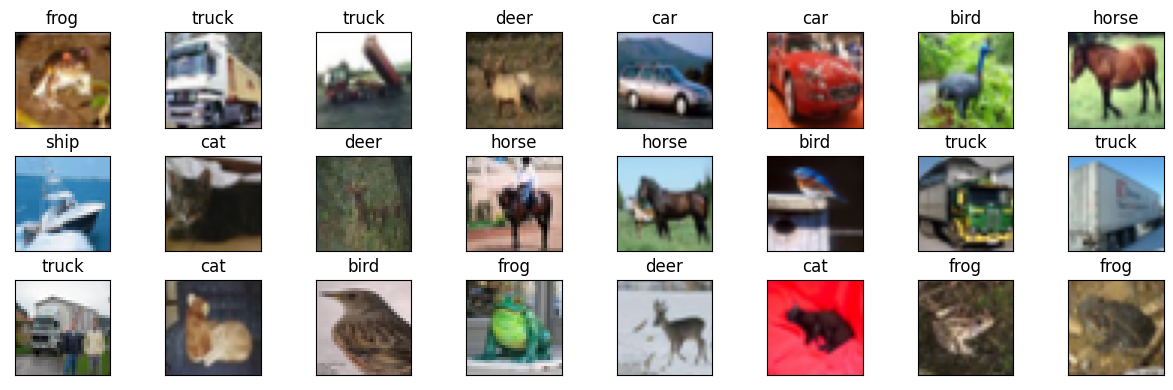

In [5]:
qtf.utils.show_images(train_images, train_labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4))

### 类别分布

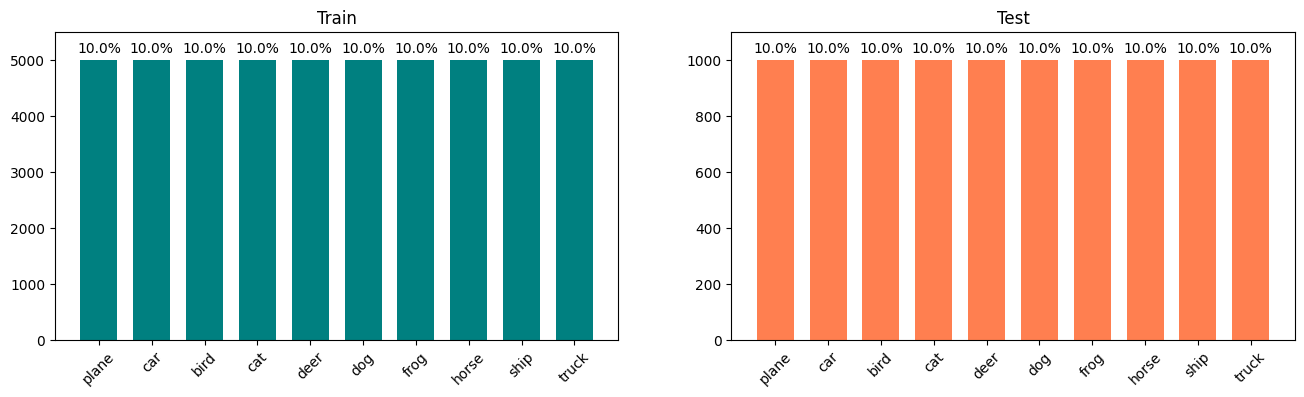

In [6]:
qtf.utils.plot_distribution(train_labels, test_labels, params.classes)



## 准备数据

不同的模型需要准备不同的数据，所以确定一下要构建哪种模型。

### 原始数据


In [7]:
raw_datasets = qtf.classification.Datasets(train_images, train_labels, test_images, test_labels, batch_size=params.batch_size)

In [8]:
sample_images, sample_labels = iter(raw_datasets.train_dataset).next()

In [9]:
raw_datasets.train_dataset.element_spec

(TensorSpec(shape=(32, 32, 32, 3), dtype=tf.float64, name=None),
 TensorSpec(shape=(32,), dtype=tf.uint8, name=None))

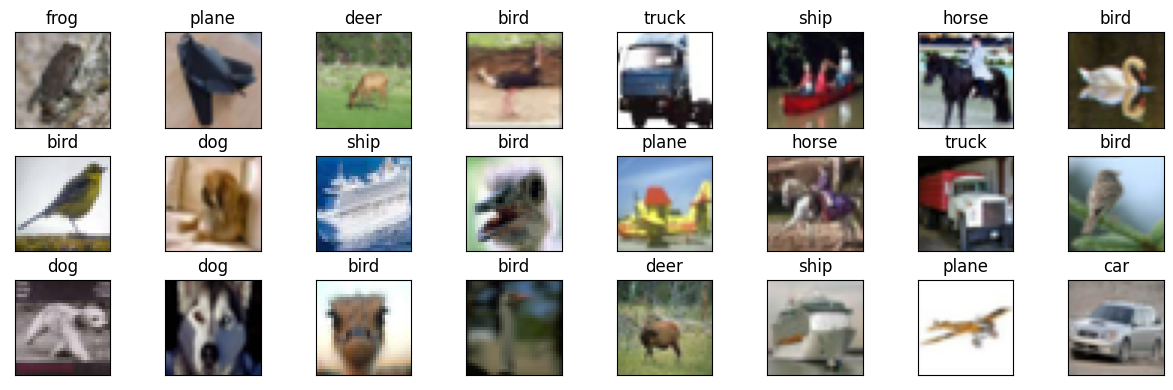

In [10]:
qtf.utils.show_images(sample_images, sample_labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4))

### 数据增强

In [11]:
data_generator.fit(train_images)
generator = {'train':qtf.classification.AugmentGenerator('augment', data_generator), 
             'val_test':qtf.classification.DatasetGenerator('val_test')}
augment_datasets = qtf.classification.Datasets(train_images, train_labels, test_images, test_labels, 
                                               generator=generator, batch_size=params.batch_size, 
                                               use_shuffle=False)

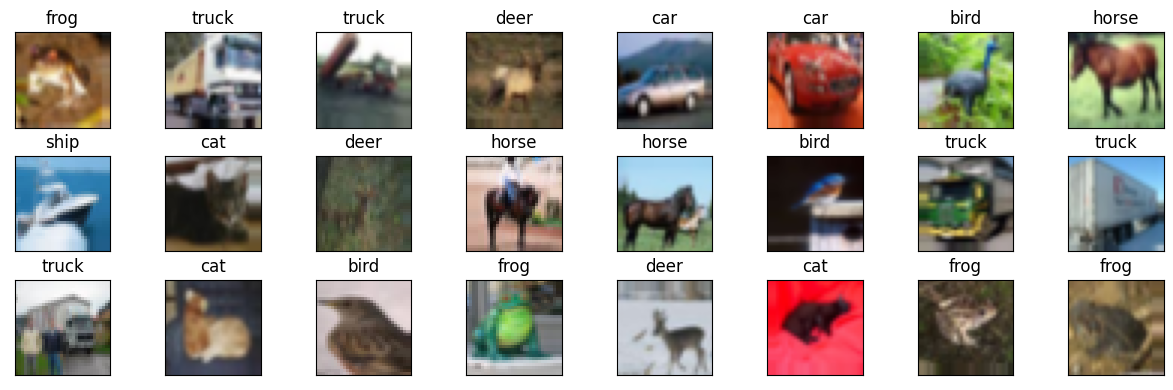

In [12]:
images, labels = iter(augment_datasets.train_dataset).next() 
qtf.utils.show_images(images, labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4)) 

看看图片原始的样子

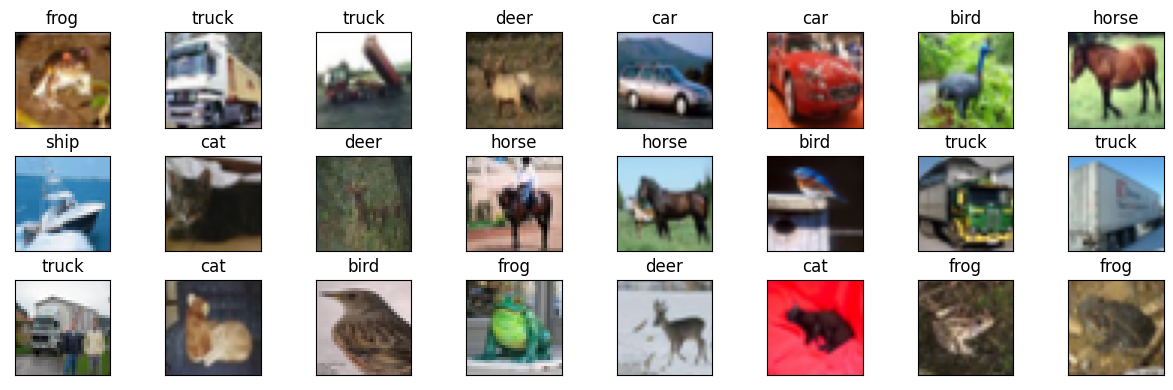

In [13]:
qtf.utils.show_images(train_images, train_labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4)) 

设置随机生成训练数据batch

In [14]:
augment_datasets = qtf.classification.Datasets(train_images, train_labels, test_images, test_labels, 
                                               generator=generator, batch_size=params.batch_size, 
                                               use_shuffle=True)

In [15]:
print(f'use_data_augmentation = {params.use_data_augmentation}')
if params.use_data_augmentation:
    datasets = augment_datasets
else:
    datasets = raw_datasets

use_data_augmentation = False


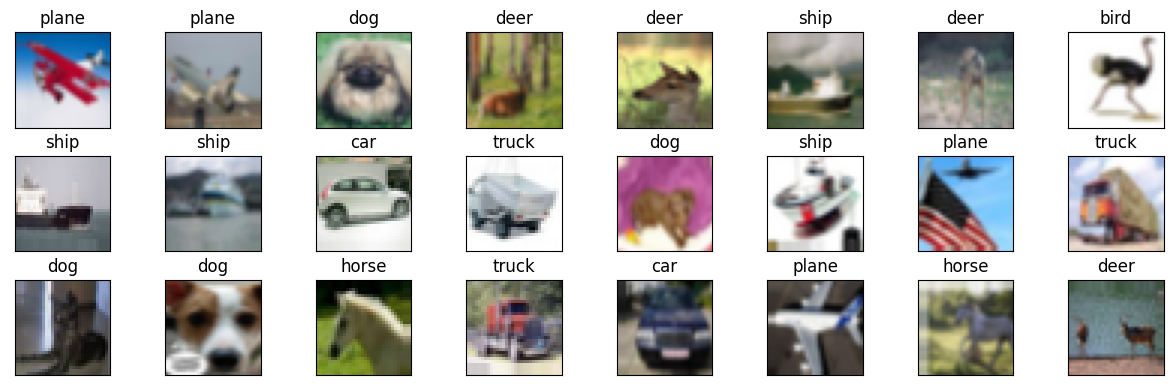

In [16]:
images, labels = iter(augment_datasets.train_dataset).next() 
qtf.utils.show_images(images, labels, classes=params.classes, x_num=3, y_num=8, figsize=(12, 4)) 



##  模型

### MLP

2021-12-02 07:23:12,326: INFO: model_params.mlp1.dropout=0.1
2021-12-02 07:23:12,326: INFO: model_params.mlp1.layer_count=1
2021-12-02 07:23:12,327: INFO: model_params.mlp1.units=128
2021-12-02 07:23:12,361: INFO: learning_rate=0.001
2021-12-02 07:23:12,362: INFO: model_params.mlp1.clip_value=None
2021-12-02 07:23:12,370: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/mlp1
2021-12-02 07:23:12,372: INFO: model_params.mlp1.epochs=120
2021-12-02 07:23:12,372: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/mlp1, monitor=val_accuracy)
2021-12-02 07:23:12,373: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2021-12-02 07:23:12,374: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2021-12-02 07:23:12,374: INFO: use LearningRateScheduler()
2021-12-02 07:23:12,

TensorSpec(shape=(32, 32, 32, 3), dtype=tf.float64, name=None)
Model: "mlp1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 128)               393344    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 394,634
Trainable params: 394,634
Non-trainable params: 0
___________________________________________________________

2021-12-02 07:23:19,762: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/mlp1/assets


1562/1562 [==============================] - 6s 4ms/step - loss: 1.9850 - accuracy: 0.2687 - val_loss: 1.8532 - val_accuracy: 0.3359 - lr: 0.0010
Epoch 2/120
1557/1562 [============================>.] - ETA: 0s - loss: 1.8752 - accuracy: 0.3163INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/mlp1/assets


2021-12-02 07:23:25,342: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/mlp1/assets


1562/1562 [==============================] - 5s 3ms/step - loss: 1.8750 - accuracy: 0.3166 - val_loss: 1.7950 - val_accuracy: 0.3598 - lr: 0.0010
Epoch 3/120
1547/1562 [============================>.] - ETA: 0s - loss: 1.8531 - accuracy: 0.3257INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/mlp1/assets


2021-12-02 07:23:30,928: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/mlp1/assets


1562/1562 [==============================] - 5s 3ms/step - loss: 1.8531 - accuracy: 0.3259 - val_loss: 1.7857 - val_accuracy: 0.3619 - lr: 0.0010
Epoch 4/120
1542/1562 [============================>.] - ETA: 0s - loss: 1.8351 - accuracy: 0.3348INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/mlp1/assets


2021-12-02 07:23:36,490: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/mlp1/assets


1562/1562 [==============================] - 5s 3ms/step - loss: 1.8347 - accuracy: 0.3349 - val_loss: 1.7648 - val_accuracy: 0.3692 - lr: 0.0010
Epoch 5/120
1549/1562 [============================>.] - ETA: 0s - loss: 1.8217 - accuracy: 0.3408INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/mlp1/assets


2021-12-02 07:23:42,106: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/mlp1/assets


1562/1562 [==============================] - 5s 3ms/step - loss: 1.8214 - accuracy: 0.3409 - val_loss: 1.7534 - val_accuracy: 0.3768 - lr: 0.0010
Epoch 6/120
1545/1562 [============================>.] - ETA: 0s - loss: 1.8079 - accuracy: 0.3477INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/mlp1/assets


2021-12-02 07:23:48,051: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/mlp1/assets


1562/1562 [==============================] - 5s 3ms/step - loss: 1.8076 - accuracy: 0.3479 - val_loss: 1.7379 - val_accuracy: 0.3809 - lr: 0.0010
Epoch 7/120
1562/1562 [==============================] - 4s 3ms/step - loss: 1.7992 - accuracy: 0.3502 - val_loss: 1.7311 - val_accuracy: 0.3775 - lr: 0.0010
Epoch 8/120
1562/1562 [==============================] - 4s 3ms/step - loss: 1.7945 - accuracy: 0.3513 - val_loss: 1.7368 - val_accuracy: 0.3775 - lr: 0.0010
Epoch 9/120
1561/1562 [============================>.] - ETA: 0s - loss: 1.7905 - accuracy: 0.3560INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/mlp1/assets


2021-12-02 07:24:03,535: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/mlp1/assets


1562/1562 [==============================] - 5s 3ms/step - loss: 1.7904 - accuracy: 0.3560 - val_loss: 1.7214 - val_accuracy: 0.3837 - lr: 0.0010
Epoch 10/120
1545/1562 [============================>.] - ETA: 0s - loss: 1.7839 - accuracy: 0.3586INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/mlp1/assets


2021-12-02 07:24:09,113: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/mlp1/assets


1562/1562 [==============================] - 5s 3ms/step - loss: 1.7838 - accuracy: 0.3586 - val_loss: 1.7246 - val_accuracy: 0.3852 - lr: 0.0010
Epoch 11/120
1555/1562 [============================>.] - ETA: 0s - loss: 1.7777 - accuracy: 0.3599INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/mlp1/assets


2021-12-02 07:24:14,766: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/mlp1/assets


1562/1562 [==============================] - 5s 3ms/step - loss: 1.7775 - accuracy: 0.3599 - val_loss: 1.7148 - val_accuracy: 0.3916 - lr: 0.0010
Epoch 12/120
1562/1562 [==============================] - 4s 3ms/step - loss: 1.7810 - accuracy: 0.3581 - val_loss: 1.7088 - val_accuracy: 0.3907 - lr: 0.0010
Epoch 13/120
1562/1562 [==============================] - 4s 3ms/step - loss: 1.7706 - accuracy: 0.3597 - val_loss: 1.7031 - val_accuracy: 0.3894 - lr: 0.0010
Epoch 14/120
1562/1562 [==============================] - 4s 3ms/step - loss: 1.7719 - accuracy: 0.3610 - val_loss: 1.7155 - val_accuracy: 0.3867 - lr: 0.0010
Epoch 15/120
1562/1562 [==============================] - 4s 3ms/step - loss: 1.7663 - accuracy: 0.3625 - val_loss: 1.7127 - val_accuracy: 0.3880 - lr: 0.0010
Epoch 16/120
1562/1562 [==============================] - 5s 3ms/step - loss: 1.7608 - accuracy: 0.3648 - val_loss: 1.7137 - val_accuracy: 0.3881 - lr: 0.0010
Epoch 17/120
1557/1562 [============================>.] - E

2021-12-02 07:24:45,437: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/mlp1/assets


1562/1562 [==============================] - 5s 3ms/step - loss: 1.7572 - accuracy: 0.3678 - val_loss: 1.6923 - val_accuracy: 0.3932 - lr: 0.0010
Epoch 18/120
1562/1562 [==============================] - 4s 3ms/step - loss: 1.7548 - accuracy: 0.3669 - val_loss: 1.7026 - val_accuracy: 0.3928 - lr: 0.0010
Epoch 19/120
1549/1562 [============================>.] - ETA: 0s - loss: 1.7555 - accuracy: 0.3671INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/mlp1/assets


2021-12-02 07:24:56,011: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/mlp1/assets


1562/1562 [==============================] - 5s 3ms/step - loss: 1.7552 - accuracy: 0.3673 - val_loss: 1.6873 - val_accuracy: 0.3962 - lr: 0.0010
Epoch 20/120
1558/1562 [============================>.] - ETA: 0s - loss: 1.7521 - accuracy: 0.3708INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/mlp1/assets


2021-12-02 07:25:01,744: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/mlp1/assets


1562/1562 [==============================] - 5s 3ms/step - loss: 1.7516 - accuracy: 0.3710 - val_loss: 1.6860 - val_accuracy: 0.3984 - lr: 0.0010
Epoch 21/120
1557/1562 [============================>.] - ETA: 0s - loss: 1.7480 - accuracy: 0.3742INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/mlp1/assets


2021-12-02 07:25:07,655: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/mlp1/assets


1562/1562 [==============================] - 5s 3ms/step - loss: 1.7478 - accuracy: 0.3744 - val_loss: 1.6860 - val_accuracy: 0.3990 - lr: 0.0010
Epoch 22/120
1562/1562 [==============================] - 4s 3ms/step - loss: 1.7427 - accuracy: 0.3723 - val_loss: 1.6894 - val_accuracy: 0.3987 - lr: 0.0010
Epoch 23/120
1562/1562 [==============================] - 4s 3ms/step - loss: 1.7460 - accuracy: 0.3734 - val_loss: 1.6848 - val_accuracy: 0.3942 - lr: 0.0010
Epoch 24/120
1562/1562 [==============================] - 4s 3ms/step - loss: 1.7406 - accuracy: 0.3742 - val_loss: 1.6819 - val_accuracy: 0.3958 - lr: 0.0010
Epoch 25/120
1562/1562 [==============================] - ETA: 0s - loss: 1.7392 - accuracy: 0.3744INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/mlp1/assets


2021-12-02 07:25:27,976: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/mlp1/assets


1562/1562 [==============================] - 5s 3ms/step - loss: 1.7392 - accuracy: 0.3744 - val_loss: 1.6806 - val_accuracy: 0.4007 - lr: 0.0010
Epoch 26/120
1562/1562 [==============================] - 5s 3ms/step - loss: 1.7378 - accuracy: 0.3738 - val_loss: 1.6867 - val_accuracy: 0.3964 - lr: 0.0010
Epoch 27/120
1562/1562 [==============================] - 4s 3ms/step - loss: 1.7345 - accuracy: 0.3754 - val_loss: 1.6808 - val_accuracy: 0.4000 - lr: 0.0010
Epoch 28/120
1562/1562 [==============================] - 4s 3ms/step - loss: 1.7337 - accuracy: 0.3776 - val_loss: 1.6869 - val_accuracy: 0.3940 - lr: 0.0010
Epoch 29/120
1562/1562 [==============================] - 4s 3ms/step - loss: 1.7326 - accuracy: 0.3772 - val_loss: 1.6821 - val_accuracy: 0.3972 - lr: 0.0010
Epoch 30/120
1549/1562 [============================>.] - ETA: 0s - loss: 1.7308 - accuracy: 0.3786INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/outp

2021-12-02 07:25:53,445: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/mlp1/assets


1562/1562 [==============================] - 5s 3ms/step - loss: 1.7304 - accuracy: 0.3789 - val_loss: 1.6748 - val_accuracy: 0.4013 - lr: 0.0010
Epoch 31/120
1562/1562 [==============================] - 4s 3ms/step - loss: 1.7274 - accuracy: 0.3787 - val_loss: 1.6941 - val_accuracy: 0.3913 - lr: 0.0010
Epoch 32/120
1544/1562 [============================>.] - ETA: 0s - loss: 1.7321 - accuracy: 0.3754INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/mlp1/assets


2021-12-02 07:26:03,894: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/mlp1/assets


1562/1562 [==============================] - 5s 3ms/step - loss: 1.7313 - accuracy: 0.3758 - val_loss: 1.6706 - val_accuracy: 0.4032 - lr: 0.0010
Epoch 33/120
1562/1562 [==============================] - 4s 3ms/step - loss: 1.7253 - accuracy: 0.3800 - val_loss: 1.6904 - val_accuracy: 0.3984 - lr: 0.0010
Epoch 34/120
1562/1562 [==============================] - 4s 3ms/step - loss: 1.7295 - accuracy: 0.3776 - val_loss: 1.6798 - val_accuracy: 0.3985 - lr: 0.0010
Epoch 35/120
1562/1562 [==============================] - 4s 3ms/step - loss: 1.7264 - accuracy: 0.3799 - val_loss: 1.6881 - val_accuracy: 0.3987 - lr: 0.0010
Epoch 36/120
1562/1562 [==============================] - 4s 3ms/step - loss: 1.7273 - accuracy: 0.3791 - val_loss: 1.6833 - val_accuracy: 0.3982 - lr: 0.0010
Epoch 37/120
1562/1562 [==============================] - 4s 3ms/step - loss: 1.7282 - accuracy: 0.3785 - val_loss: 1.6825 - val_accuracy: 0.3986 - lr: 0.0010
Epoch 38/120
1562/1562 [==============================] - 4

2021-12-02 07:27:24,017: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/mlp1/assets


1562/1562 [==============================] - 5s 3ms/step - loss: 1.6927 - accuracy: 0.3948 - val_loss: 1.6636 - val_accuracy: 0.4054 - lr: 3.1623e-04
Epoch 00049: Still keep learning rate 0.0003162 instead of 0.001
Epoch 49/120
1548/1562 [============================>.] - ETA: 0s - loss: 1.6940 - accuracy: 0.3937INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/mlp1/assets


2021-12-02 07:27:29,722: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/mlp1/assets


1562/1562 [==============================] - 5s 3ms/step - loss: 1.6935 - accuracy: 0.3939 - val_loss: 1.6648 - val_accuracy: 0.4057 - lr: 3.1623e-04
Epoch 00050: Still keep learning rate 0.0003162 instead of 0.001
Epoch 50/120
1562/1562 [==============================] - 4s 3ms/step - loss: 1.6914 - accuracy: 0.3940 - val_loss: 1.6672 - val_accuracy: 0.4036 - lr: 3.1623e-04
Epoch 00051: Still keep learning rate 0.0003162 instead of 0.001
Epoch 51/120
1562/1562 [==============================] - 4s 3ms/step - loss: 1.6888 - accuracy: 0.3945 - val_loss: 1.6661 - val_accuracy: 0.4031 - lr: 3.1623e-04
Epoch 00052: Still keep learning rate 0.0003162 instead of 0.001
Epoch 52/120
1562/1562 [==============================] - 4s 3ms/step - loss: 1.6938 - accuracy: 0.3923 - val_loss: 1.6696 - val_accuracy: 0.4043 - lr: 3.1623e-04
Epoch 00053: Still keep learning rate 0.0003162 instead of 0.001
Epoch 53/120
1562/1562 [==============================] - 5s 3ms/step - loss: 1.6878 - accuracy: 0.39

2021-12-02 07:27:55,335: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/mlp1/assets


1562/1562 [==============================] - 5s 3ms/step - loss: 1.6917 - accuracy: 0.3944 - val_loss: 1.6636 - val_accuracy: 0.4079 - lr: 3.1623e-04
Epoch 00055: Still keep learning rate 0.0003162 instead of 0.001
Epoch 55/120
1562/1562 [==============================] - 4s 3ms/step - loss: 1.6877 - accuracy: 0.3941 - val_loss: 1.6689 - val_accuracy: 0.4019 - lr: 3.1623e-04
Epoch 00056: Still keep learning rate 0.0003162 instead of 0.001
Epoch 56/120
1562/1562 [==============================] - 4s 3ms/step - loss: 1.6880 - accuracy: 0.3953 - val_loss: 1.6640 - val_accuracy: 0.4030 - lr: 3.1623e-04
Epoch 00057: Still keep learning rate 0.0003162 instead of 0.001
Epoch 57/120
1562/1562 [==============================] - 4s 3ms/step - loss: 1.6905 - accuracy: 0.3958 - val_loss: 1.6612 - val_accuracy: 0.4064 - lr: 3.1623e-04
Epoch 00058: Still keep learning rate 0.0003162 instead of 0.001
Epoch 58/120
1562/1562 [==============================] - 5s 3ms/step - loss: 1.6878 - accuracy: 0.39

2021-12-02 07:30:14,671: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/mlp1/assets


1562/1562 [==============================] - 5s 3ms/step - loss: 1.6724 - accuracy: 0.4013 - val_loss: 1.6573 - val_accuracy: 0.4090 - lr: 3.1623e-05
Epoch 00083: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 83/120
1554/1562 [============================>.] - ETA: 0s - loss: 1.6718 - accuracy: 0.4037INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/mlp1/assets


2021-12-02 07:30:20,336: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/mlp1/assets


1562/1562 [==============================] - 5s 3ms/step - loss: 1.6716 - accuracy: 0.4038 - val_loss: 1.6577 - val_accuracy: 0.4093 - lr: 3.1623e-05
Epoch 00084: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 84/120
1562/1562 [==============================] - 4s 3ms/step - loss: 1.6720 - accuracy: 0.4020 - val_loss: 1.6579 - val_accuracy: 0.4085 - lr: 3.1623e-05
Epoch 00085: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 85/120
1562/1562 [==============================] - 4s 3ms/step - loss: 1.6736 - accuracy: 0.4007 - val_loss: 1.6581 - val_accuracy: 0.4083 - lr: 3.1623e-05
Epoch 00086: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 86/120
1562/1562 [==============================] - 4s 3ms/step - loss: 1.6720 - accuracy: 0.4024 - val_loss: 1.6577 - val_accuracy: 0.4092 - lr: 3.1623e-05
Epoch 00087: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 87/120
1562/1562 [==============================] - 4s 3ms/step - loss: 1.6708 - accuracy: 0.40

2021-12-02 07:33:24,779: INFO: finish training [elapsed time: 612.40 seconds]


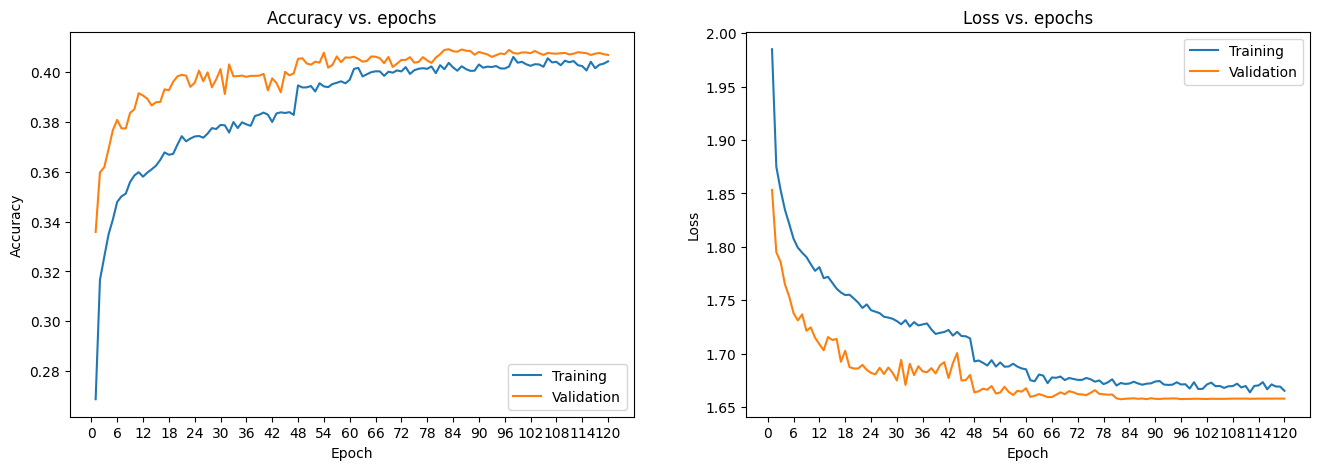

2021-12-02 07:33:25,243: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/mlp1


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/mlp1
----------------------------------------evaluate----------------------------------------
y_score.shape=(50000, 10)
y_true.shape=(50000, 10)
len(y_true.shape)=2


2021-12-02 07:33:41,865: INFO: test loss:1.6577
2021-12-02 07:33:41,866: INFO: test accuracy:0.4093
2021-12-02 07:33:41,867: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/results.json
2021-12-02 07:33:41,868: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/results.json
2021-12-02 07:33:41,868: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/default.generator
2021-12-02 07:33:41,870: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/default.generator


y_score.shape=(10000, 10)
y_true.shape=(10000, 10)
len(y_true.shape)=2
----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


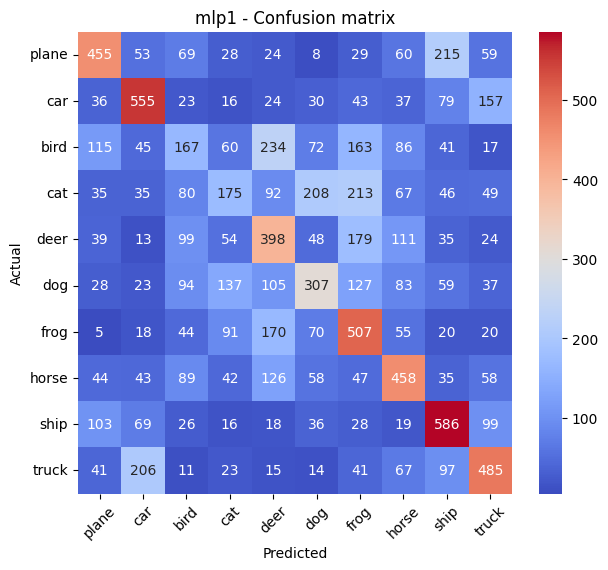

----------------------------------------sample analysis----------------------------------------


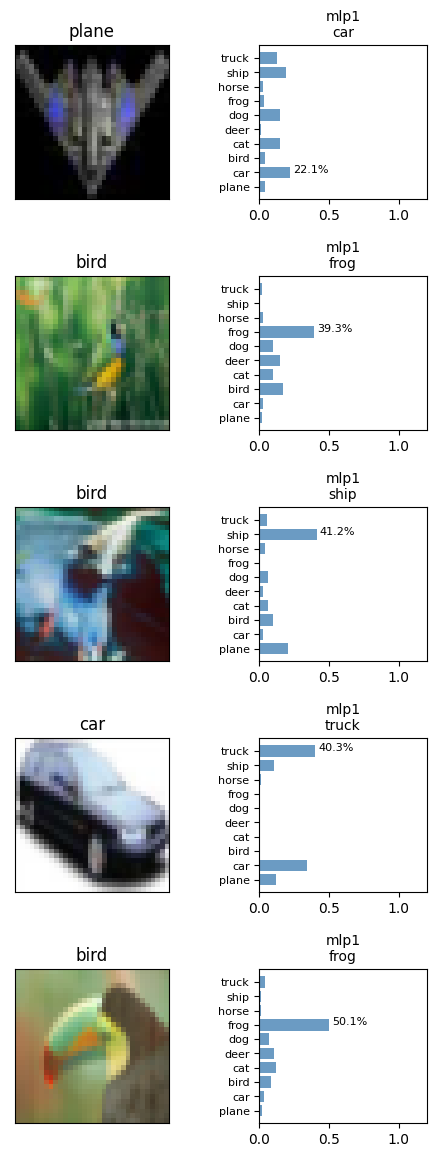

----------------------------------------models----------------------------------------


,model_name,program_name,weight_number,train_time,create_time,train_loss,test_loss,train_accuracy,test_accuracy,train_auc,test_auc
1,mlp1,cifar10_0721_p100.ipynb,394634,612.4,2021-12-02 07:33,1.5857,1.6577,0.4421,0.4093,0.85,0.8316


In [17]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.mlp1(helper, name='mlp1')
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True) 




从上面的错误来看，模型对一些细节的判断不是很准。下面来尝试一下LeNet。

### LeNet

![image-20201019113632136](images/image-20201019113632136.png)

LeNet诞生于1994年，是Yann LeCun等人提出的，是最早的卷积神经网络之一。在LeNet中，输入层是32×32的图片，而MNIST是28×28的图片，为了保持模型的结构不变，在第一个Conv2D设置参数padding=’same’。首先创建模型，并训练。

2021-12-02 07:33:46,157: INFO: model_params.lenet1.dropout=0.2
2021-12-02 07:33:46,239: INFO: learning_rate=0.001
2021-12-02 07:33:46,239: INFO: model_params.lenet1.clip_value=None
2021-12-02 07:33:46,244: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/lenet1
2021-12-02 07:33:46,249: INFO: model_params.lenet1.epochs=120
2021-12-02 07:33:46,249: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/lenet1, monitor=val_accuracy)
2021-12-02 07:33:46,250: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2021-12-02 07:33:46,250: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2021-12-02 07:33:46,251: INFO: use LearningRateScheduler()
2021-12-02 07:33:46,252: INFO: steps_per_epoch=1562
2021-12-02 07:33:46,252: INFO: start training
2021-12-02 07:33:46,253: INFO: use

TensorSpec(shape=(32, 32, 32, 3), dtype=tf.float64, name=None)
Model: "lenet1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 6)         456       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 6)        24        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 6)        0         
 )                                                               
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 6)         0         
                                                               

2021-12-02 07:33:58,786: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/lenet1/assets


1562/1562 [==============================] - 11s 6ms/step - loss: 1.7211 - accuracy: 0.3775 - val_loss: 1.5263 - val_accuracy: 0.4607 - lr: 0.0010
Epoch 2/120
1555/1562 [============================>.] - ETA: 0s - loss: 1.4479 - accuracy: 0.4802INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/lenet1/assets


2021-12-02 07:34:09,095: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/lenet1/assets


1562/1562 [==============================] - 10s 6ms/step - loss: 1.4473 - accuracy: 0.4805 - val_loss: 1.3205 - val_accuracy: 0.5257 - lr: 0.0010
Epoch 3/120
1554/1562 [============================>.] - ETA: 0s - loss: 1.3413 - accuracy: 0.5262INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/lenet1/assets


2021-12-02 07:34:19,392: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/lenet1/assets


1562/1562 [==============================] - 10s 6ms/step - loss: 1.3409 - accuracy: 0.5265 - val_loss: 1.1923 - val_accuracy: 0.5811 - lr: 0.0010
Epoch 4/120
1560/1562 [============================>.] - ETA: 0s - loss: 1.2606 - accuracy: 0.5563INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/lenet1/assets


2021-12-02 07:34:30,143: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/lenet1/assets


1562/1562 [==============================] - 10s 7ms/step - loss: 1.2603 - accuracy: 0.5565 - val_loss: 1.1615 - val_accuracy: 0.5927 - lr: 0.0010
Epoch 5/120
1562/1562 [==============================] - 8s 5ms/step - loss: 1.2025 - accuracy: 0.5783 - val_loss: 1.1509 - val_accuracy: 0.5902 - lr: 0.0010
Epoch 6/120
1562/1562 [==============================] - 8s 5ms/step - loss: 1.1600 - accuracy: 0.5933 - val_loss: 1.2797 - val_accuracy: 0.5608 - lr: 0.0010
Epoch 7/120
1562/1562 [==============================] - 8s 5ms/step - loss: 1.1253 - accuracy: 0.6058 - val_loss: 1.2904 - val_accuracy: 0.5570 - lr: 0.0010
Epoch 8/120
1559/1562 [============================>.] - ETA: 0s - loss: 1.0977 - accuracy: 0.6146INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/lenet1/assets


2021-12-02 07:35:06,030: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/lenet1/assets


1562/1562 [==============================] - 10s 6ms/step - loss: 1.0975 - accuracy: 0.6147 - val_loss: 1.0865 - val_accuracy: 0.6161 - lr: 0.0010
Epoch 9/120
1562/1562 [==============================] - 9s 5ms/step - loss: 1.0713 - accuracy: 0.6235 - val_loss: 1.1107 - val_accuracy: 0.6064 - lr: 0.0010
Epoch 10/120
1552/1562 [============================>.] - ETA: 0s - loss: 1.0552 - accuracy: 0.6271INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/lenet1/assets


2021-12-02 07:35:26,311: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/lenet1/assets


1562/1562 [==============================] - 11s 7ms/step - loss: 1.0550 - accuracy: 0.6272 - val_loss: 1.0094 - val_accuracy: 0.6478 - lr: 0.0010
Epoch 11/120
1562/1562 [==============================] - 9s 6ms/step - loss: 1.0308 - accuracy: 0.6385 - val_loss: 1.0289 - val_accuracy: 0.6413 - lr: 0.0010
Epoch 12/120
1562/1562 [==============================] - 9s 6ms/step - loss: 1.0134 - accuracy: 0.6437 - val_loss: 1.0062 - val_accuracy: 0.6453 - lr: 0.0010
Epoch 13/120
1562/1562 [==============================] - 9s 6ms/step - loss: 1.0022 - accuracy: 0.6467 - val_loss: 1.0951 - val_accuracy: 0.6132 - lr: 0.0010
Epoch 14/120
1562/1562 [==============================] - 10s 6ms/step - loss: 0.9854 - accuracy: 0.6541 - val_loss: 1.0022 - val_accuracy: 0.6472 - lr: 0.0010
Epoch 15/120
1557/1562 [============================>.] - ETA: 0s - loss: 0.9745 - accuracy: 0.6559INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/ou

2021-12-02 07:36:18,547: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/lenet1/assets


1562/1562 [==============================] - 12s 8ms/step - loss: 0.9744 - accuracy: 0.6560 - val_loss: 0.9362 - val_accuracy: 0.6701 - lr: 0.0010
Epoch 16/120
1552/1562 [============================>.] - ETA: 0s - loss: 0.9704 - accuracy: 0.6586INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/lenet1/assets


2021-12-02 07:36:36,975: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/lenet1/assets


1562/1562 [==============================] - 10s 6ms/step - loss: 0.9700 - accuracy: 0.6588 - val_loss: 0.8979 - val_accuracy: 0.6864 - lr: 0.0010
Epoch 17/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.9516 - accuracy: 0.6654 - val_loss: 1.1005 - val_accuracy: 0.6168 - lr: 0.0010
Epoch 18/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.9443 - accuracy: 0.6683 - val_loss: 0.9388 - val_accuracy: 0.6717 - lr: 0.0010
Epoch 19/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.9349 - accuracy: 0.6711 - val_loss: 0.9104 - val_accuracy: 0.6814 - lr: 0.0010
Epoch 20/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.9243 - accuracy: 0.6741 - val_loss: 1.1197 - val_accuracy: 0.6187 - lr: 0.0010
Epoch 21/120
1559/1562 [============================>.] - ETA: 0s - loss: 0.9157 - accuracy: 0.6765INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/out

2021-12-02 07:37:22,339: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/lenet1/assets


1562/1562 [==============================] - 10s 7ms/step - loss: 0.9154 - accuracy: 0.6766 - val_loss: 0.9006 - val_accuracy: 0.6865 - lr: 0.0010
Epoch 22/120
1554/1562 [============================>.] - ETA: 0s - loss: 0.9128 - accuracy: 0.6772INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/lenet1/assets


2021-12-02 07:37:33,156: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/lenet1/assets


1562/1562 [==============================] - 10s 7ms/step - loss: 0.9125 - accuracy: 0.6774 - val_loss: 0.8594 - val_accuracy: 0.7021 - lr: 0.0010
Epoch 23/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.9025 - accuracy: 0.6799 - val_loss: 1.0124 - val_accuracy: 0.6521 - lr: 0.0010
Epoch 24/120
1561/1562 [============================>.] - ETA: 0s - loss: 0.9029 - accuracy: 0.6816INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/lenet1/assets


2021-12-02 07:37:52,541: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/lenet1/assets


1562/1562 [==============================] - 10s 7ms/step - loss: 0.9028 - accuracy: 0.6816 - val_loss: 0.8500 - val_accuracy: 0.7040 - lr: 0.0010
Epoch 25/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.8889 - accuracy: 0.6870 - val_loss: 0.9013 - val_accuracy: 0.6849 - lr: 0.0010
Epoch 26/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.8863 - accuracy: 0.6885 - val_loss: 0.9208 - val_accuracy: 0.6780 - lr: 0.0010
Epoch 27/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.8781 - accuracy: 0.6909 - val_loss: 0.9672 - val_accuracy: 0.6651 - lr: 0.0010
Epoch 28/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.8782 - accuracy: 0.6916 - val_loss: 1.0347 - val_accuracy: 0.6335 - lr: 0.0010
Epoch 29/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.8683 - accuracy: 0.6958 - val_loss: 0.8909 - val_accuracy: 0.6887 - lr: 0.0010
Epoch 30/120
1562/1562 [==============================] - 

2021-12-02 07:39:54,577: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/lenet1/assets


1562/1562 [==============================] - 10s 7ms/step - loss: 0.8332 - accuracy: 0.7048 - val_loss: 0.8373 - val_accuracy: 0.7096 - lr: 0.0010
Epoch 39/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.8303 - accuracy: 0.7073 - val_loss: 0.8434 - val_accuracy: 0.7094 - lr: 0.0010
Epoch 40/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.8369 - accuracy: 0.7049 - val_loss: 0.9533 - val_accuracy: 0.6672 - lr: 0.0010
Epoch 41/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.8242 - accuracy: 0.7098 - val_loss: 0.8332 - val_accuracy: 0.7085 - lr: 0.0010
Epoch 42/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.8215 - accuracy: 0.7082 - val_loss: 0.8393 - val_accuracy: 0.7084 - lr: 0.0010
Epoch 43/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.8247 - accuracy: 0.7083 - val_loss: 0.8711 - val_accuracy: 0.7011 - lr: 0.0010
Epoch 44/120
1562/1562 [==============================] - 

2021-12-02 07:42:12,487: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/lenet1/assets


1562/1562 [==============================] - 10s 7ms/step - loss: 0.7977 - accuracy: 0.7179 - val_loss: 0.8373 - val_accuracy: 0.7110 - lr: 0.0010
Epoch 55/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.7971 - accuracy: 0.7183 - val_loss: 0.8719 - val_accuracy: 0.6957 - lr: 0.0010
Epoch 56/120
1555/1562 [============================>.] - ETA: 0s - loss: 0.7986 - accuracy: 0.7161
Epoch 00056: ReduceLROnPlateau reducing learning rate to 0.00031622778103685084.
1562/1562 [==============================] - 8s 5ms/step - loss: 0.7979 - accuracy: 0.7163 - val_loss: 0.9494 - val_accuracy: 0.6728 - lr: 3.1623e-04
Epoch 00057: Still keep learning rate 0.0003162 instead of 0.001
Epoch 57/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.7593 - accuracy: 0.7317 - val_loss: 0.8679 - val_accuracy: 0.7003 - lr: 3.1623e-04
Epoch 00058: Still keep learning rate 0.0003162 instead of 0.001
Epoch 58/120
1559/1562 [============================>.] - ETA: 0s - lo

2021-12-02 07:42:48,941: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/lenet1/assets


1562/1562 [==============================] - 10s 7ms/step - loss: 0.7553 - accuracy: 0.7334 - val_loss: 0.8077 - val_accuracy: 0.7229 - lr: 3.1623e-04
Epoch 00059: Still keep learning rate 0.0003162 instead of 0.001
Epoch 59/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.7487 - accuracy: 0.7334 - val_loss: 0.8247 - val_accuracy: 0.7151 - lr: 3.1623e-04
Epoch 00060: Still keep learning rate 0.0003162 instead of 0.001
Epoch 60/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.7493 - accuracy: 0.7373 - val_loss: 0.8095 - val_accuracy: 0.7217 - lr: 3.1623e-04
Epoch 00061: LearningRateScheduler reducing learning rate to 0.0001 from 0.0003162.
Epoch 61/120
1555/1562 [============================>.] - ETA: 0s - loss: 0.7339 - accuracy: 0.7401INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/lenet1/assets


2021-12-02 07:43:17,411: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/lenet1/assets


1562/1562 [==============================] - 11s 7ms/step - loss: 0.7336 - accuracy: 0.7403 - val_loss: 0.7878 - val_accuracy: 0.7281 - lr: 1.0000e-04
Epoch 62/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.7321 - accuracy: 0.7400 - val_loss: 0.7933 - val_accuracy: 0.7260 - lr: 1.0000e-04
Epoch 63/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.7239 - accuracy: 0.7420 - val_loss: 0.7986 - val_accuracy: 0.7257 - lr: 1.0000e-04
Epoch 64/120
1552/1562 [============================>.] - ETA: 0s - loss: 0.7278 - accuracy: 0.7432INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/lenet1/assets


2021-12-02 07:43:45,149: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/lenet1/assets


1562/1562 [==============================] - 10s 7ms/step - loss: 0.7277 - accuracy: 0.7431 - val_loss: 0.7893 - val_accuracy: 0.7305 - lr: 1.0000e-04
Epoch 65/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.7325 - accuracy: 0.7411 - val_loss: 0.7957 - val_accuracy: 0.7248 - lr: 1.0000e-04
Epoch 66/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.7360 - accuracy: 0.7391 - val_loss: 0.8008 - val_accuracy: 0.7275 - lr: 1.0000e-04
Epoch 67/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.7304 - accuracy: 0.7393 - val_loss: 0.8009 - val_accuracy: 0.7216 - lr: 1.0000e-04
Epoch 68/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.7240 - accuracy: 0.7433 - val_loss: 0.7975 - val_accuracy: 0.7273 - lr: 1.0000e-04
Epoch 69/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.7234 - accuracy: 0.7430 - val_loss: 0.8036 - val_accuracy: 0.7244 - lr: 1.0000e-04
Epoch 70/120
1562/1562 [==========

2021-12-02 07:46:12,645: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/lenet1/assets


1562/1562 [==============================] - 10s 6ms/step - loss: 0.7236 - accuracy: 0.7457 - val_loss: 0.7877 - val_accuracy: 0.7325 - lr: 1.0000e-04
Epoch 82/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.7232 - accuracy: 0.7424 - val_loss: 0.7830 - val_accuracy: 0.7321 - lr: 1.0000e-04
Epoch 83/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.7192 - accuracy: 0.7461 - val_loss: 0.7926 - val_accuracy: 0.7275 - lr: 1.0000e-04
Epoch 84/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.7215 - accuracy: 0.7460 - val_loss: 0.7871 - val_accuracy: 0.7309 - lr: 1.0000e-04
Epoch 85/120
1553/1562 [============================>.] - ETA: 0s - loss: 0.7199 - accuracy: 0.7454
Epoch 00085: ReduceLROnPlateau reducing learning rate to 3.1622775802825264e-05.
1562/1562 [==============================] - 8s 5ms/step - loss: 0.7197 - accuracy: 0.7452 - val_loss: 0.7834 - val_accuracy: 0.7309 - lr: 3.1623e-05
Epoch 00086: Still keep learn

2021-12-02 07:49:23,853: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/lenet1/assets


1562/1562 [==============================] - 10s 7ms/step - loss: 0.7087 - accuracy: 0.7473 - val_loss: 0.7808 - val_accuracy: 0.7326 - lr: 1.0000e-05
Epoch 104/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.7109 - accuracy: 0.7476 - val_loss: 0.7825 - val_accuracy: 0.7316 - lr: 1.0000e-05
Epoch 105/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.7104 - accuracy: 0.7468 - val_loss: 0.7827 - val_accuracy: 0.7306 - lr: 1.0000e-05
Epoch 00106: LearningRateScheduler reducing learning rate to 1e-06 from 1e-05.
Epoch 106/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.7088 - accuracy: 0.7478 - val_loss: 0.7815 - val_accuracy: 0.7310 - lr: 1.0000e-06
Epoch 107/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.7087 - accuracy: 0.7490 - val_loss: 0.7812 - val_accuracy: 0.7315 - lr: 1.0000e-06
Epoch 108/120
1562/1562 [==============================] - 8s 5ms/step - loss: 0.7126 - accuracy: 0.7463 - val_los

2021-12-02 07:51:48,777: INFO: finish training [elapsed time: 1082.52 seconds]


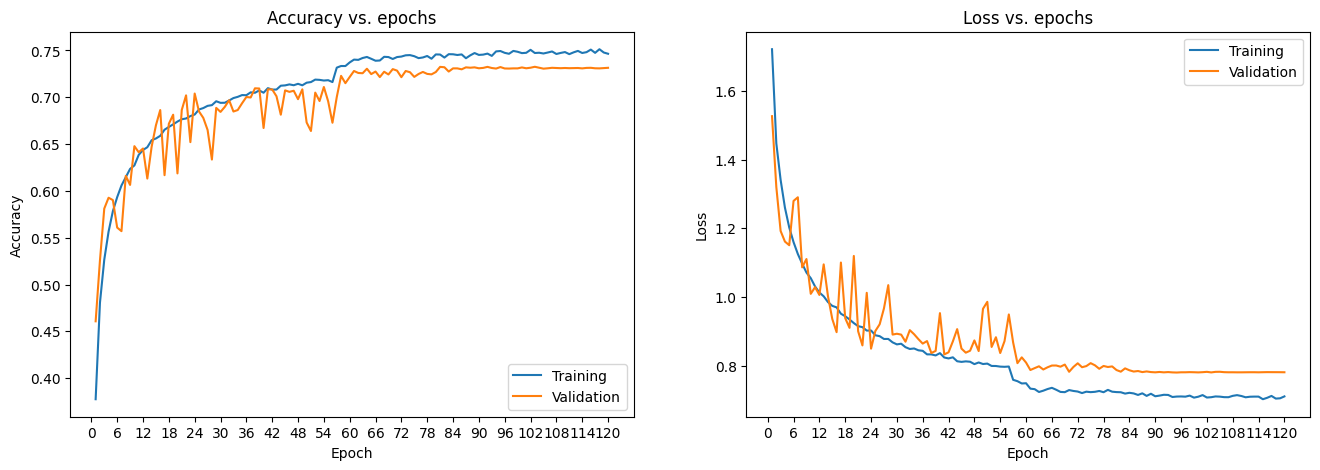

2021-12-02 07:51:49,254: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/lenet1


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/lenet1
----------------------------------------evaluate----------------------------------------
y_score.shape=(50000, 10)
y_true.shape=(50000, 10)
len(y_true.shape)=2


2021-12-02 07:52:09,014: INFO: test loss:0.7808
2021-12-02 07:52:09,015: INFO: test accuracy:0.7326
2021-12-02 07:52:09,017: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/results.json
2021-12-02 07:52:09,018: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/results.json
2021-12-02 07:52:09,019: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/default.generator
2021-12-02 07:52:09,020: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/default.generator
2021-12-02 07:52:09,020: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/mlp1


y_score.shape=(10000, 10)
y_true.shape=(10000, 10)
len(y_true.shape)=2
----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2021-12-02 07:52:09,301: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/default.generator


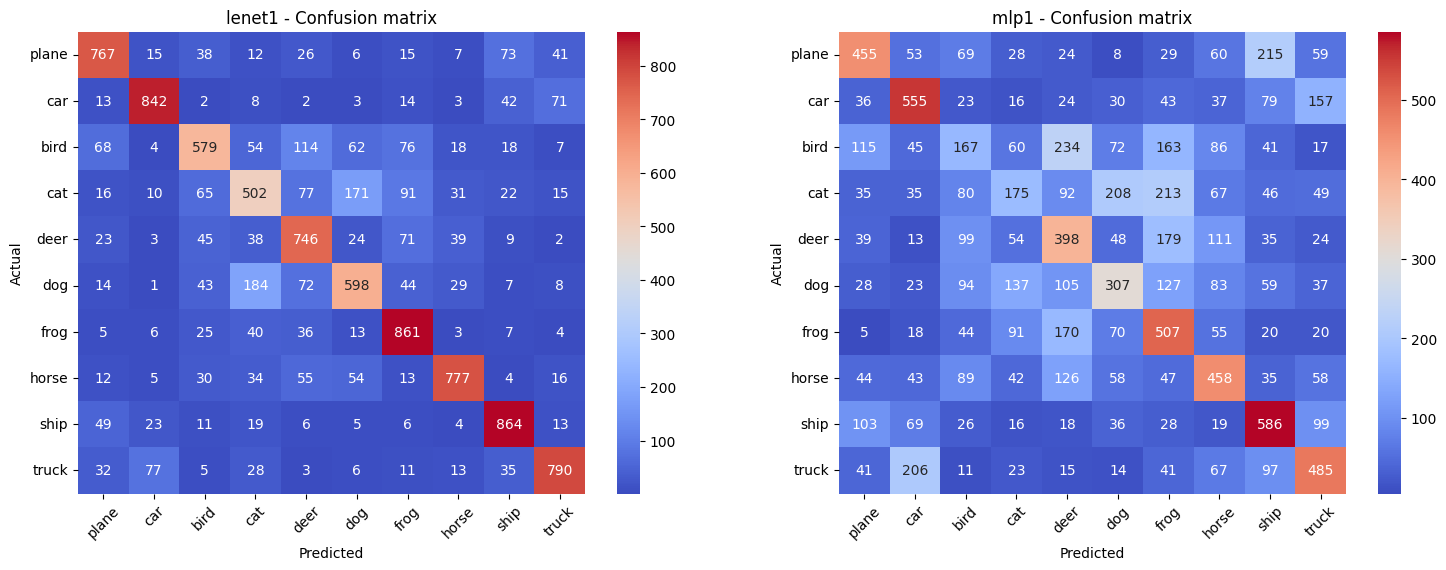

2021-12-02 07:52:13,519: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/mlp1


----------------------------------------sample analysis----------------------------------------


2021-12-02 07:52:13,801: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/default.generator


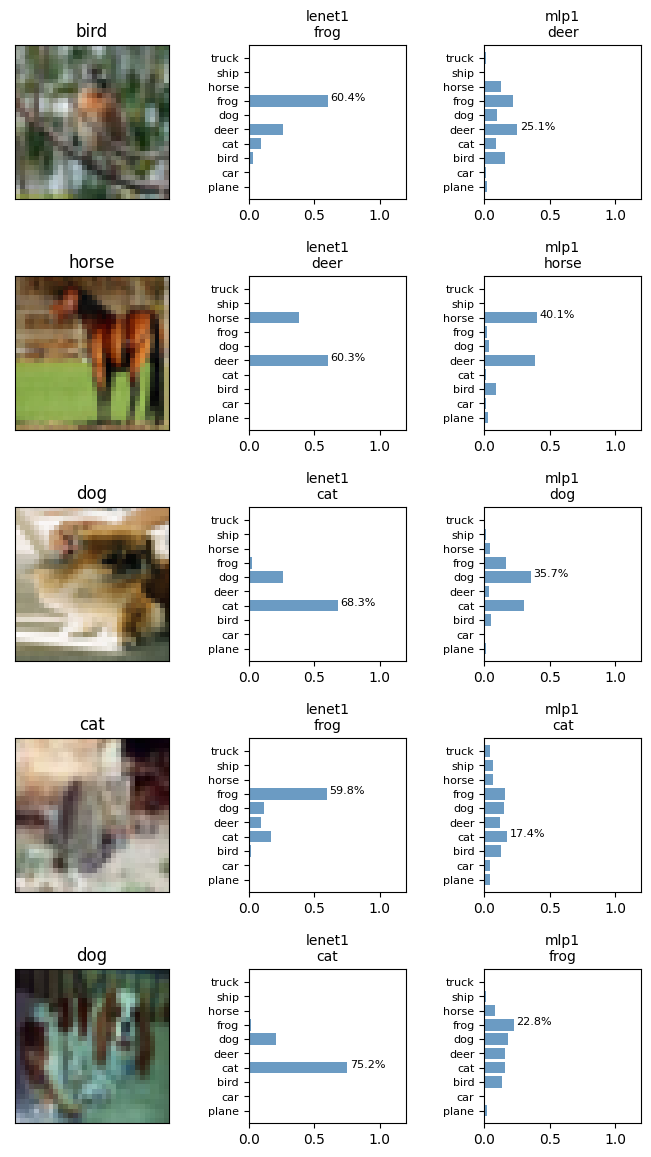

----------------------------------------models----------------------------------------


,model_name,program_name,weight_number,train_time,create_time,train_loss,test_loss,train_accuracy,test_accuracy,train_auc,test_auc
1,lenet1,cifar10_0721_p100.ipynb,83170,1082.5,2021-12-02 07:52,0.4513,0.7808,0.8461,0.7326,0.9878,0.9628
2,mlp1,cifar10_0721_p100.ipynb,394634,612.4,2021-12-02 07:33,1.5857,1.6577,0.4421,0.4093,0.8500,0.8316


In [18]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.lenet1(helper, name='lenet1')
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True) 

从上面的图中，可以看到，Lenet的参数只有mlp的60%，但其的准确率比mlp提升了差不多1%。上面最后一张图中，有三列，第一列是数字图片，它们是mlp中分错的数字，第二列是mlp中的分类，第三列是lenet中的分类，可以看到lenet的确学到了一些mlp中没有的模式。下面再来看看哪些数字在lenet也分错了。

### Custom 1

下面自己定义一个模型，这个模型和lenet的主要区别是，增加了卷积的深度

2021-12-02 07:52:17,970: INFO: model_params.custom1.dropout=0.2
2021-12-02 07:52:18,072: INFO: learning_rate=0.001
2021-12-02 07:52:18,073: INFO: model_params.custom1.clip_value=None
2021-12-02 07:52:18,079: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/custom1
2021-12-02 07:52:18,084: INFO: model_params.custom1.epochs=120
2021-12-02 07:52:18,084: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/custom1, monitor=val_accuracy)
2021-12-02 07:52:18,085: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2021-12-02 07:52:18,085: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2021-12-02 07:52:18,086: INFO: use LearningRateScheduler()
2021-12-02 07:52:18,086: INFO: steps_per_epoch=1562
2021-12-02 07:52:18,087: INFO: start training
2021-12-02 07:52:18,087: INFO

TensorSpec(shape=(32, 32, 32, 3), dtype=tf.float64, name=None)
Model: "custom1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 batch_normalization_2 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 16, 16, 32)        0         
                                                              

2021-12-02 07:52:31,935: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/custom1/assets


1562/1562 [==============================] - 13s 8ms/step - loss: 1.6364 - accuracy: 0.4111 - val_loss: 1.2935 - val_accuracy: 0.5228 - lr: 0.0010
Epoch 2/120
1556/1562 [============================>.] - ETA: 0s - loss: 1.2772 - accuracy: 0.5447INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/custom1/assets


2021-12-02 07:52:44,825: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/custom1/assets


1562/1562 [==============================] - 12s 8ms/step - loss: 1.2768 - accuracy: 0.5447 - val_loss: 1.1195 - val_accuracy: 0.5969 - lr: 0.0010
Epoch 3/120
1562/1562 [==============================] - 9s 6ms/step - loss: 1.1390 - accuracy: 0.5960 - val_loss: 1.1741 - val_accuracy: 0.5833 - lr: 0.0010
Epoch 4/120
1562/1562 [==============================] - 9s 6ms/step - loss: 1.0569 - accuracy: 0.6265 - val_loss: 1.2868 - val_accuracy: 0.5741 - lr: 0.0010
Epoch 5/120
1558/1562 [============================>.] - ETA: 0s - loss: 1.0010 - accuracy: 0.6485INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/custom1/assets


2021-12-02 07:53:16,825: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/custom1/assets


1562/1562 [==============================] - 12s 8ms/step - loss: 1.0006 - accuracy: 0.6486 - val_loss: 0.9485 - val_accuracy: 0.6668 - lr: 0.0010
Epoch 6/120
1561/1562 [============================>.] - ETA: 0s - loss: 0.9577 - accuracy: 0.6643INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/custom1/assets


2021-12-02 07:53:29,153: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/custom1/assets


1562/1562 [==============================] - 12s 8ms/step - loss: 0.9576 - accuracy: 0.6643 - val_loss: 0.8699 - val_accuracy: 0.6935 - lr: 0.0010
Epoch 7/120
1558/1562 [============================>.] - ETA: 0s - loss: 0.9306 - accuracy: 0.6742INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/custom1/assets


2021-12-02 07:53:41,971: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/custom1/assets


1562/1562 [==============================] - 12s 8ms/step - loss: 0.9304 - accuracy: 0.6742 - val_loss: 0.8383 - val_accuracy: 0.7030 - lr: 0.0010
Epoch 8/120
1562/1562 [==============================] - 9s 6ms/step - loss: 0.9005 - accuracy: 0.6850 - val_loss: 0.9998 - val_accuracy: 0.6536 - lr: 0.0010
Epoch 9/120
1553/1562 [============================>.] - ETA: 0s - loss: 0.8804 - accuracy: 0.6901INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/custom1/assets


2021-12-02 07:54:03,902: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/custom1/assets


1562/1562 [==============================] - 12s 7ms/step - loss: 0.8800 - accuracy: 0.6902 - val_loss: 0.8299 - val_accuracy: 0.7123 - lr: 0.0010
Epoch 10/120
1562/1562 [==============================] - 9s 6ms/step - loss: 0.8529 - accuracy: 0.7023 - val_loss: 0.8451 - val_accuracy: 0.7038 - lr: 0.0010
Epoch 11/120
1562/1562 [==============================] - 9s 6ms/step - loss: 0.8379 - accuracy: 0.7093 - val_loss: 0.9168 - val_accuracy: 0.6798 - lr: 0.0010
Epoch 12/120
1559/1562 [============================>.] - ETA: 0s - loss: 0.8243 - accuracy: 0.7107INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/custom1/assets


2021-12-02 07:54:36,252: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/custom1/assets


1562/1562 [==============================] - 12s 8ms/step - loss: 0.8240 - accuracy: 0.7108 - val_loss: 0.7408 - val_accuracy: 0.7434 - lr: 0.0010
Epoch 13/120
1562/1562 [==============================] - 10s 6ms/step - loss: 0.8146 - accuracy: 0.7156 - val_loss: 0.8265 - val_accuracy: 0.7187 - lr: 0.0010
Epoch 14/120
1562/1562 [==============================] - 9s 6ms/step - loss: 0.8008 - accuracy: 0.7199 - val_loss: 0.8031 - val_accuracy: 0.7251 - lr: 0.0010
Epoch 15/120
1562/1562 [==============================] - 10s 6ms/step - loss: 0.7876 - accuracy: 0.7250 - val_loss: 0.8525 - val_accuracy: 0.7041 - lr: 0.0010
Epoch 16/120
1562/1562 [==============================] - 9s 6ms/step - loss: 0.7754 - accuracy: 0.7284 - val_loss: 0.8044 - val_accuracy: 0.7193 - lr: 0.0010
Epoch 17/120
1562/1562 [==============================] - 9s 6ms/step - loss: 0.7691 - accuracy: 0.7318 - val_loss: 0.9032 - val_accuracy: 0.6962 - lr: 0.0010
Epoch 18/120
1562/1562 [==============================] 

2021-12-02 07:57:17,209: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/custom1/assets


1562/1562 [==============================] - 12s 8ms/step - loss: 0.6602 - accuracy: 0.7698 - val_loss: 0.6770 - val_accuracy: 0.7684 - lr: 3.1623e-04
Epoch 00029: Still keep learning rate 0.0003162 instead of 0.001
Epoch 29/120
1557/1562 [============================>.] - ETA: 0s - loss: 0.6559 - accuracy: 0.7692INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/custom1/assets


2021-12-02 07:57:29,703: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/custom1/assets


1562/1562 [==============================] - 12s 8ms/step - loss: 0.6558 - accuracy: 0.7692 - val_loss: 0.6534 - val_accuracy: 0.7750 - lr: 3.1623e-04
Epoch 00030: Still keep learning rate 0.0003162 instead of 0.001
Epoch 30/120
1562/1562 [==============================] - 9s 6ms/step - loss: 0.6441 - accuracy: 0.7735 - val_loss: 0.6518 - val_accuracy: 0.7746 - lr: 3.1623e-04
Epoch 00031: Still keep learning rate 0.0003162 instead of 0.001
Epoch 31/120
1562/1562 [==============================] - 9s 6ms/step - loss: 0.6393 - accuracy: 0.7765 - val_loss: 0.6890 - val_accuracy: 0.7615 - lr: 3.1623e-04
Epoch 00032: Still keep learning rate 0.0003162 instead of 0.001
Epoch 32/120
1562/1562 [==============================] - 9s 6ms/step - loss: 0.6380 - accuracy: 0.7769 - val_loss: 0.6851 - val_accuracy: 0.7668 - lr: 3.1623e-04
Epoch 00033: Still keep learning rate 0.0003162 instead of 0.001
Epoch 33/120
1562/1562 [==============================] - 9s 6ms/step - loss: 0.6348 - accuracy: 0.7

2021-12-02 07:58:41,985: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/custom1/assets


1562/1562 [==============================] - 12s 8ms/step - loss: 0.6251 - accuracy: 0.7806 - val_loss: 0.6273 - val_accuracy: 0.7880 - lr: 3.1623e-04
Epoch 00037: Still keep learning rate 0.0003162 instead of 0.001
Epoch 37/120
1562/1562 [==============================] - 9s 6ms/step - loss: 0.6242 - accuracy: 0.7807 - val_loss: 0.6430 - val_accuracy: 0.7813 - lr: 3.1623e-04
Epoch 00038: Still keep learning rate 0.0003162 instead of 0.001
Epoch 38/120
1562/1562 [==============================] - 9s 6ms/step - loss: 0.6217 - accuracy: 0.7810 - val_loss: 0.7499 - val_accuracy: 0.7477 - lr: 3.1623e-04
Epoch 00039: Still keep learning rate 0.0003162 instead of 0.001
Epoch 39/120
1562/1562 [==============================] - 9s 6ms/step - loss: 0.6174 - accuracy: 0.7839 - val_loss: 0.6343 - val_accuracy: 0.7837 - lr: 3.1623e-04
Epoch 00040: Still keep learning rate 0.0003162 instead of 0.001
Epoch 40/120
1562/1562 [==============================] - 10s 6ms/step - loss: 0.6136 - accuracy: 0.

2021-12-02 08:00:09,257: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/custom1/assets


1562/1562 [==============================] - 14s 9ms/step - loss: 0.6155 - accuracy: 0.7823 - val_loss: 0.6273 - val_accuracy: 0.7883 - lr: 3.1623e-04
Epoch 00045: Still keep learning rate 0.0003162 instead of 0.001
Epoch 45/120
1562/1562 [==============================] - 10s 7ms/step - loss: 0.6056 - accuracy: 0.7877 - val_loss: 0.6360 - val_accuracy: 0.7844 - lr: 3.1623e-04
Epoch 00046: Still keep learning rate 0.0003162 instead of 0.001
Epoch 46/120
1562/1562 [==============================] - 9s 6ms/step - loss: 0.6079 - accuracy: 0.7865 - val_loss: 0.6562 - val_accuracy: 0.7797 - lr: 3.1623e-04
Epoch 00047: Still keep learning rate 0.0003162 instead of 0.001
Epoch 47/120
1562/1562 [==============================] - 10s 6ms/step - loss: 0.6042 - accuracy: 0.7879 - val_loss: 0.6813 - val_accuracy: 0.7698 - lr: 3.1623e-04
Epoch 00048: Still keep learning rate 0.0003162 instead of 0.001
Epoch 48/120
1562/1562 [==============================] - 9s 6ms/step - loss: 0.6113 - accuracy: 0

2021-12-02 08:01:33,059: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/custom1/assets


1562/1562 [==============================] - 12s 8ms/step - loss: 0.5888 - accuracy: 0.7924 - val_loss: 0.6148 - val_accuracy: 0.7910 - lr: 1.0000e-04
Epoch 00053: Still keep learning rate 0.0001 instead of 0.001
Epoch 53/120
1562/1562 [==============================] - 10s 6ms/step - loss: 0.5860 - accuracy: 0.7951 - val_loss: 0.6361 - val_accuracy: 0.7857 - lr: 1.0000e-04
Epoch 00054: Still keep learning rate 0.0001 instead of 0.001
Epoch 54/120
1561/1562 [============================>.] - ETA: 0s - loss: 0.5874 - accuracy: 0.7949INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/custom1/assets


2021-12-02 08:01:55,687: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/custom1/assets


1562/1562 [==============================] - 12s 7ms/step - loss: 0.5873 - accuracy: 0.7949 - val_loss: 0.6221 - val_accuracy: 0.7918 - lr: 1.0000e-04
Epoch 00055: Still keep learning rate 0.0001 instead of 0.001
Epoch 55/120
1562/1562 [==============================] - 10s 6ms/step - loss: 0.5838 - accuracy: 0.7933 - val_loss: 0.6221 - val_accuracy: 0.7888 - lr: 1.0000e-04
Epoch 00056: Still keep learning rate 0.0001 instead of 0.001
Epoch 56/120
1562/1562 [==============================] - 10s 6ms/step - loss: 0.5793 - accuracy: 0.7949 - val_loss: 0.6144 - val_accuracy: 0.7918 - lr: 1.0000e-04
Epoch 00057: Still keep learning rate 0.0001 instead of 0.001
Epoch 57/120
1562/1562 [==============================] - 9s 6ms/step - loss: 0.5802 - accuracy: 0.7983 - val_loss: 0.6186 - val_accuracy: 0.7887 - lr: 1.0000e-04
Epoch 00058: Still keep learning rate 0.0001 instead of 0.001
Epoch 58/120
1562/1562 [==============================] - 9s 6ms/step - loss: 0.5799 - accuracy: 0.7938 - val_

2021-12-02 08:03:08,276: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/custom1/assets


1562/1562 [==============================] - 12s 8ms/step - loss: 0.5795 - accuracy: 0.7954 - val_loss: 0.6061 - val_accuracy: 0.7936 - lr: 1.0000e-04
Epoch 62/120
1562/1562 [==============================] - 9s 6ms/step - loss: 0.5825 - accuracy: 0.7964 - val_loss: 0.6201 - val_accuracy: 0.7896 - lr: 1.0000e-04
Epoch 63/120
1562/1562 [==============================] - 9s 6ms/step - loss: 0.5778 - accuracy: 0.7980 - val_loss: 0.6148 - val_accuracy: 0.7920 - lr: 1.0000e-04
Epoch 64/120
1562/1562 [==============================] - 9s 6ms/step - loss: 0.5798 - accuracy: 0.7940 - val_loss: 0.6324 - val_accuracy: 0.7872 - lr: 1.0000e-04
Epoch 65/120
1562/1562 [==============================] - 9s 6ms/step - loss: 0.5747 - accuracy: 0.7959 - val_loss: 0.6129 - val_accuracy: 0.7884 - lr: 1.0000e-04
Epoch 66/120
1562/1562 [==============================] - 9s 6ms/step - loss: 0.5728 - accuracy: 0.8013 - val_loss: 0.6085 - val_accuracy: 0.7921 - lr: 1.0000e-04
Epoch 67/120
1562/1562 [==========

2021-12-02 08:05:29,495: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/custom1/assets


1562/1562 [==============================] - 12s 8ms/step - loss: 0.5691 - accuracy: 0.7996 - val_loss: 0.6094 - val_accuracy: 0.7947 - lr: 1.0000e-04
Epoch 76/120
1556/1562 [============================>.] - ETA: 0s - loss: 0.5684 - accuracy: 0.7983
Epoch 00076: ReduceLROnPlateau reducing learning rate to 3.1622775802825264e-05.
1562/1562 [==============================] - 10s 6ms/step - loss: 0.5686 - accuracy: 0.7982 - val_loss: 0.6131 - val_accuracy: 0.7896 - lr: 3.1623e-05
Epoch 00077: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 77/120
1562/1562 [==============================] - 10s 6ms/step - loss: 0.5641 - accuracy: 0.8010 - val_loss: 0.6098 - val_accuracy: 0.7914 - lr: 3.1623e-05
Epoch 00078: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 78/120
1562/1562 [==============================] - 9s 6ms/step - loss: 0.5623 - accuracy: 0.8032 - val_loss: 0.6083 - val_accuracy: 0.7937 - lr: 3.1623e-05
Epoch 00079: Still keep learning rate 3.16e-05 instead of 0.

2021-12-02 08:12:08,888: INFO: finish training [elapsed time: 1190.80 seconds]


Epoch 00115: early stopping


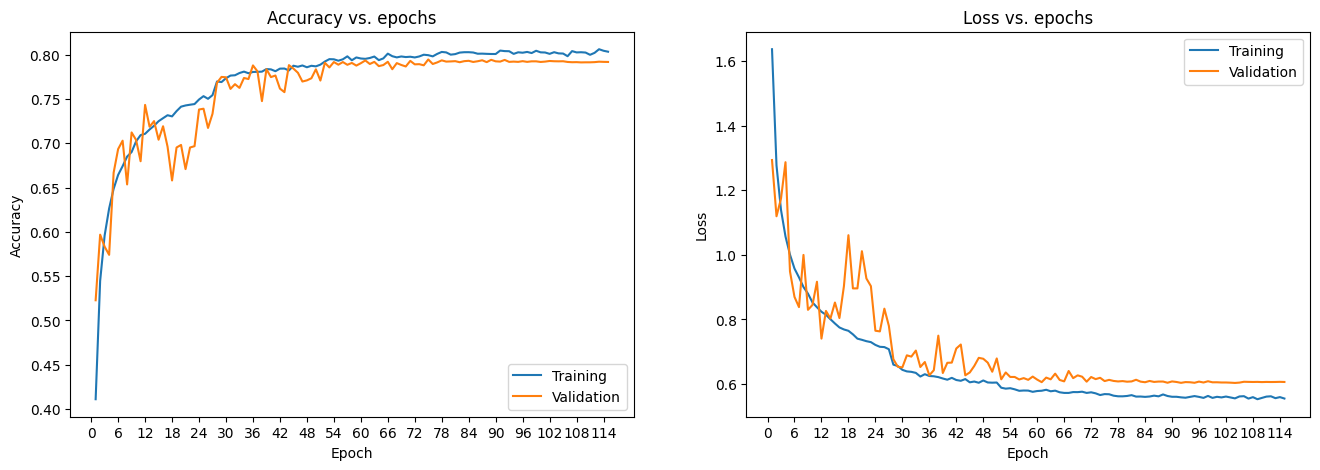

2021-12-02 08:12:09,422: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/custom1


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/custom1
----------------------------------------evaluate----------------------------------------
y_score.shape=(50000, 10)
y_true.shape=(50000, 10)
len(y_true.shape)=2


2021-12-02 08:12:31,368: INFO: test loss:0.6094
2021-12-02 08:12:31,369: INFO: test accuracy:0.7947
2021-12-02 08:12:31,371: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/results.json
2021-12-02 08:12:31,372: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/results.json
2021-12-02 08:12:31,372: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/default.generator
2021-12-02 08:12:31,373: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/default.generator
2021-12-02 08:12:31,374: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/lenet1


y_score.shape=(10000, 10)
y_true.shape=(10000, 10)
len(y_true.shape)=2
----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2021-12-02 08:12:32,233: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/default.generator


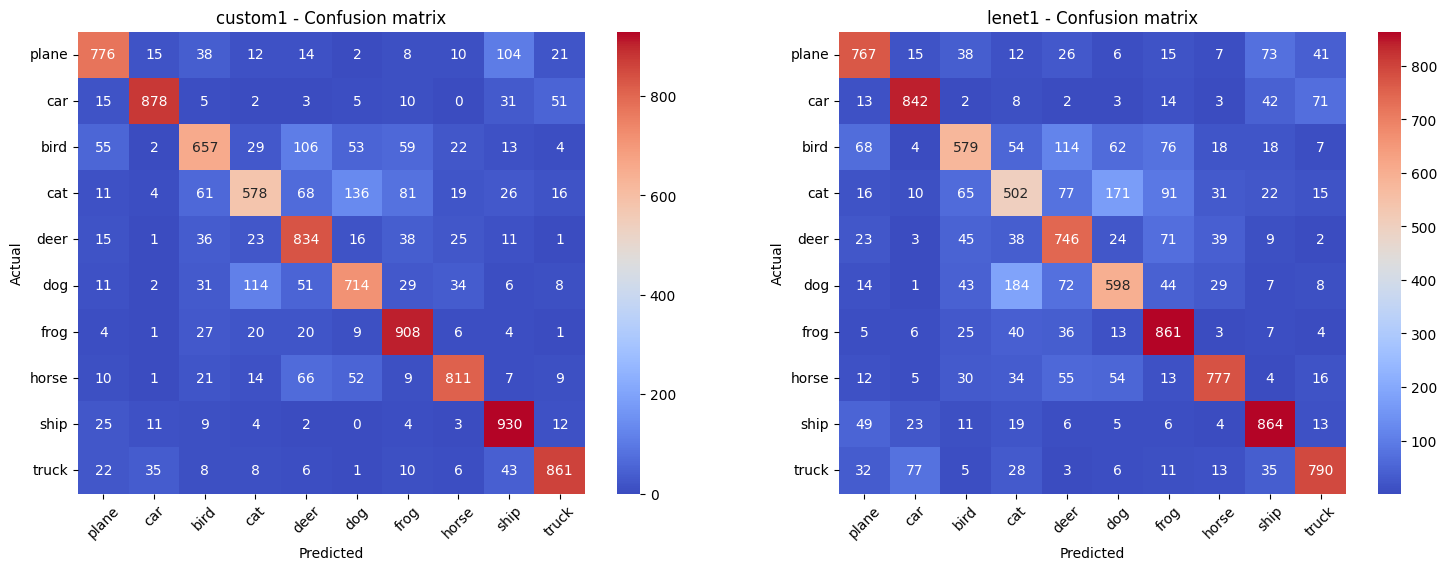

2021-12-02 08:12:37,094: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/lenet1


----------------------------------------sample analysis----------------------------------------


2021-12-02 08:12:37,961: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/default.generator
2021-12-02 08:12:37,964: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/mlp1
2021-12-02 08:12:38,231: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/default.generator


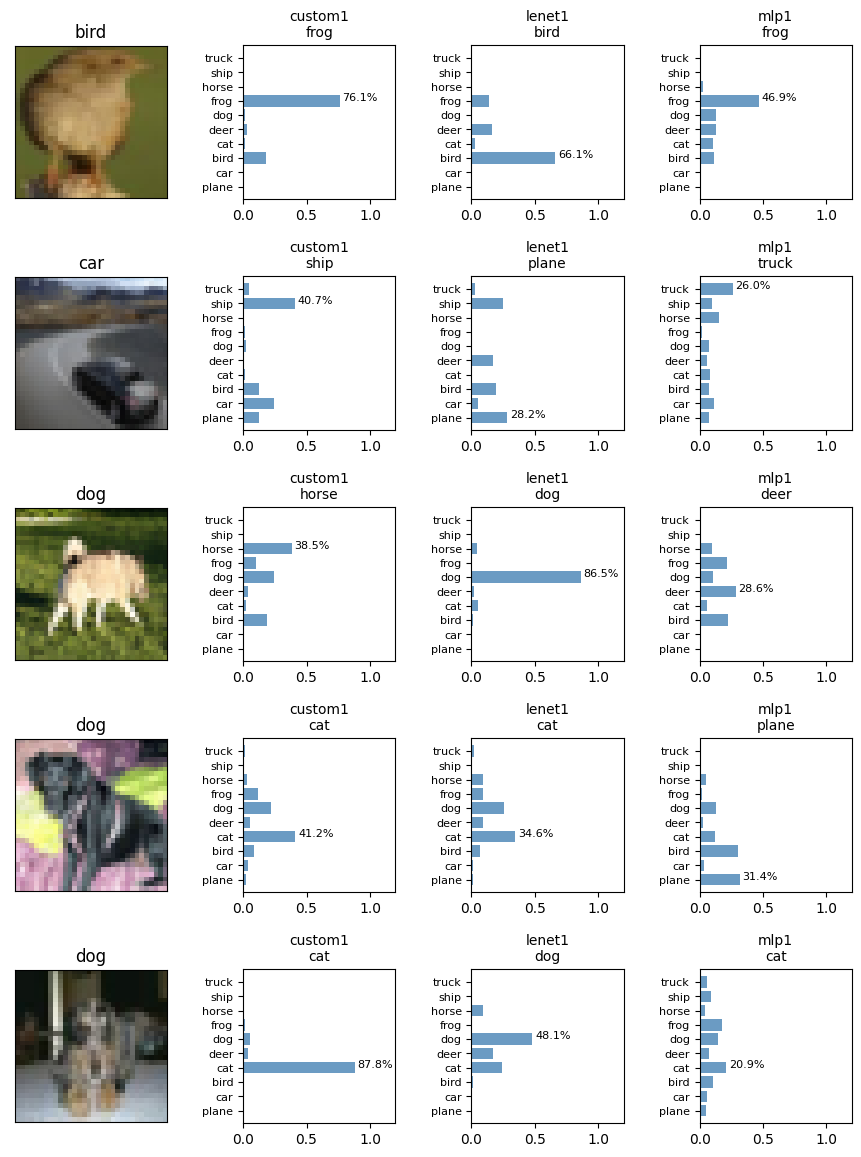

----------------------------------------models----------------------------------------


,model_name,program_name,weight_number,train_time,create_time,train_loss,test_loss,train_accuracy,test_accuracy,train_auc,test_auc
1,custom1,cifar10_0721_p100.ipynb,73738,1190.8,2021-12-02 08:12,0.3420,0.6094,0.8832,0.7947,0.9929,0.9776
2,lenet1,cifar10_0721_p100.ipynb,83170,1082.5,2021-12-02 07:52,0.4513,0.7808,0.8461,0.7326,0.9878,0.9628
3,mlp1,cifar10_0721_p100.ipynb,394634,612.4,2021-12-02 07:33,1.5857,1.6577,0.4421,0.4093,0.8500,0.8316


In [19]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.custom1(helper, name='custom1')
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True) 

### VGG

2021-12-02 08:12:42,656: INFO: model_params.vgg8.dropout=0.4


TensorSpec(shape=(32, 32, 32, 3), dtype=tf.float64, name=None)


2021-12-02 08:12:42,825: INFO: learning_rate=0.001
2021-12-02 08:12:42,825: INFO: model_params.vgg8.clip_value=None
2021-12-02 08:12:42,831: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/vgg8
2021-12-02 08:12:42,841: INFO: model_params.vgg8.epochs=120
2021-12-02 08:12:42,842: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/vgg8, monitor=val_accuracy)
2021-12-02 08:12:42,842: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2021-12-02 08:12:42,843: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2021-12-02 08:12:42,843: INFO: use LearningRateScheduler()
2021-12-02 08:12:42,844: INFO: steps_per_epoch=1562
2021-12-02 08:12:42,844: INFO: start training
2021-12-02 08:12:42,845: INFO: use_class_weight=False


Model: "vgg8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 block1_con1 (Conv2D)        (None, 32, 32, 64)        1792      
                                                                 
 block1_bn1 (BatchNormalizat  (None, 32, 32, 64)       256       
 ion)                                                            
                                                                 
 block1_relu1 (ReLU)         (None, 32, 32, 64)        0         
                                                                 
 block1_con2 (Conv2D)        (None, 32, 32, 64)        36928     
                                                                 
 block1_bn2 (BatchNormalizat  (None, 32, 32, 64)       256       
 ion)                                                         

2021-12-02 08:13:06,401: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/vgg8/assets


1562/1562 [==============================] - 23s 14ms/step - loss: 2.0840 - accuracy: 0.2114 - val_loss: 1.8512 - val_accuracy: 0.2982 - lr: 0.0010
Epoch 2/120
1558/1562 [============================>.] - ETA: 0s - loss: 1.9100 - accuracy: 0.2642INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/vgg8/assets


2021-12-02 08:13:29,115: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/vgg8/assets


1562/1562 [==============================] - 22s 14ms/step - loss: 1.9098 - accuracy: 0.2642 - val_loss: 1.7150 - val_accuracy: 0.3395 - lr: 0.0010
Epoch 3/120
1560/1562 [============================>.] - ETA: 0s - loss: 1.7472 - accuracy: 0.3369INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/vgg8/assets


2021-12-02 08:13:51,177: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/vgg8/assets


1562/1562 [==============================] - 21s 14ms/step - loss: 1.7469 - accuracy: 0.3370 - val_loss: 1.6220 - val_accuracy: 0.4056 - lr: 0.0010
Epoch 4/120
1557/1562 [============================>.] - ETA: 0s - loss: 1.6297 - accuracy: 0.3820INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/vgg8/assets


2021-12-02 08:14:13,532: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/vgg8/assets


1562/1562 [==============================] - 22s 14ms/step - loss: 1.6294 - accuracy: 0.3821 - val_loss: 1.3464 - val_accuracy: 0.5266 - lr: 0.0010
Epoch 5/120
1562/1562 [==============================] - 17s 11ms/step - loss: 1.4939 - accuracy: 0.4285 - val_loss: 1.3250 - val_accuracy: 0.5250 - lr: 0.0010
Epoch 6/120
1560/1562 [============================>.] - ETA: 0s - loss: 1.4096 - accuracy: 0.4607INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/vgg8/assets


2021-12-02 08:14:53,022: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/vgg8/assets


1562/1562 [==============================] - 22s 14ms/step - loss: 1.4096 - accuracy: 0.4607 - val_loss: 1.1901 - val_accuracy: 0.5562 - lr: 0.0010
Epoch 7/120
1560/1562 [============================>.] - ETA: 0s - loss: 1.3300 - accuracy: 0.4912INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/vgg8/assets


2021-12-02 08:15:15,174: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/vgg8/assets


1562/1562 [==============================] - 22s 14ms/step - loss: 1.3299 - accuracy: 0.4913 - val_loss: 1.1170 - val_accuracy: 0.5828 - lr: 0.0010
Epoch 8/120
1558/1562 [============================>.] - ETA: 0s - loss: 1.2195 - accuracy: 0.5338INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/vgg8/assets


2021-12-02 08:15:37,300: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/vgg8/assets


1562/1562 [==============================] - 22s 14ms/step - loss: 1.2191 - accuracy: 0.5340 - val_loss: 1.0925 - val_accuracy: 0.5856 - lr: 0.0010
Epoch 9/120
1560/1562 [============================>.] - ETA: 0s - loss: 1.0935 - accuracy: 0.5849INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/vgg8/assets


2021-12-02 08:15:59,619: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/vgg8/assets


1562/1562 [==============================] - 22s 14ms/step - loss: 1.0931 - accuracy: 0.5850 - val_loss: 0.8841 - val_accuracy: 0.6867 - lr: 0.0010
Epoch 10/120
1557/1562 [============================>.] - ETA: 0s - loss: 0.9743 - accuracy: 0.6516INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/vgg8/assets


2021-12-02 08:16:21,988: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/vgg8/assets


1562/1562 [==============================] - 22s 14ms/step - loss: 0.9737 - accuracy: 0.6517 - val_loss: 0.7246 - val_accuracy: 0.7498 - lr: 0.0010
Epoch 11/120
1558/1562 [============================>.] - ETA: 0s - loss: 0.8793 - accuracy: 0.6928INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/vgg8/assets


2021-12-02 08:16:44,430: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/vgg8/assets


1562/1562 [==============================] - 22s 14ms/step - loss: 0.8792 - accuracy: 0.6927 - val_loss: 0.7319 - val_accuracy: 0.7526 - lr: 0.0010
Epoch 12/120
1561/1562 [============================>.] - ETA: 0s - loss: 0.8129 - accuracy: 0.7157INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/vgg8/assets


2021-12-02 08:17:07,160: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/vgg8/assets


1562/1562 [==============================] - 22s 14ms/step - loss: 0.8127 - accuracy: 0.7158 - val_loss: 0.6374 - val_accuracy: 0.7861 - lr: 0.0010
Epoch 13/120
1562/1562 [==============================] - 17s 11ms/step - loss: 0.7187 - accuracy: 0.7530 - val_loss: 0.6883 - val_accuracy: 0.7680 - lr: 0.0010
Epoch 14/120
1557/1562 [============================>.] - ETA: 0s - loss: 0.6325 - accuracy: 0.7858INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/vgg8/assets


2021-12-02 08:17:46,166: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/vgg8/assets


1562/1562 [==============================] - 21s 13ms/step - loss: 0.6321 - accuracy: 0.7859 - val_loss: 0.6016 - val_accuracy: 0.8048 - lr: 0.0010
Epoch 15/120
1557/1562 [============================>.] - ETA: 0s - loss: 0.5798 - accuracy: 0.8063INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/vgg8/assets


2021-12-02 08:18:07,742: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/vgg8/assets


1562/1562 [==============================] - 21s 14ms/step - loss: 0.5800 - accuracy: 0.8063 - val_loss: 0.5951 - val_accuracy: 0.8089 - lr: 0.0010
Epoch 16/120
1560/1562 [============================>.] - ETA: 0s - loss: 0.5406 - accuracy: 0.8152INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/vgg8/assets


2021-12-02 08:18:28,530: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/vgg8/assets


1562/1562 [==============================] - 21s 13ms/step - loss: 0.5403 - accuracy: 0.8154 - val_loss: 0.6125 - val_accuracy: 0.8094 - lr: 0.0010
Epoch 17/120
1562/1562 [==============================] - 17s 11ms/step - loss: 0.4993 - accuracy: 0.8302 - val_loss: 0.6583 - val_accuracy: 0.8017 - lr: 0.0010
Epoch 18/120
1557/1562 [============================>.] - ETA: 0s - loss: 0.4754 - accuracy: 0.8391INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/vgg8/assets


2021-12-02 08:19:06,581: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/vgg8/assets


1562/1562 [==============================] - 21s 13ms/step - loss: 0.4755 - accuracy: 0.8391 - val_loss: 0.5773 - val_accuracy: 0.8261 - lr: 0.0010
Epoch 19/120
1557/1562 [============================>.] - ETA: 0s - loss: 0.4501 - accuracy: 0.8477INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/vgg8/assets


2021-12-02 08:19:28,176: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/vgg8/assets


1562/1562 [==============================] - 21s 14ms/step - loss: 0.4499 - accuracy: 0.8479 - val_loss: 0.5238 - val_accuracy: 0.8362 - lr: 0.0010
Epoch 20/120
1562/1562 [==============================] - 17s 11ms/step - loss: 0.4210 - accuracy: 0.8572 - val_loss: 0.7516 - val_accuracy: 0.7992 - lr: 0.0010
Epoch 21/120
1561/1562 [============================>.] - ETA: 0s - loss: 0.4067 - accuracy: 0.8610INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/vgg8/assets


2021-12-02 08:20:06,375: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/vgg8/assets


1562/1562 [==============================] - 21s 14ms/step - loss: 0.4066 - accuracy: 0.8611 - val_loss: 0.5144 - val_accuracy: 0.8404 - lr: 0.0010
Epoch 22/120
1559/1562 [============================>.] - ETA: 0s - loss: 0.3802 - accuracy: 0.8704INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/vgg8/assets


2021-12-02 08:20:28,536: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/vgg8/assets


1562/1562 [==============================] - 22s 14ms/step - loss: 0.3801 - accuracy: 0.8704 - val_loss: 0.5414 - val_accuracy: 0.8433 - lr: 0.0010
Epoch 23/120
1562/1562 [==============================] - ETA: 0s - loss: 0.3604 - accuracy: 0.8770INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/vgg8/assets


2021-12-02 08:20:50,453: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/vgg8/assets


1562/1562 [==============================] - 22s 14ms/step - loss: 0.3604 - accuracy: 0.8770 - val_loss: 0.5145 - val_accuracy: 0.8510 - lr: 0.0010
Epoch 24/120
1562/1562 [==============================] - 18s 11ms/step - loss: 0.3452 - accuracy: 0.8827 - val_loss: 0.6417 - val_accuracy: 0.8264 - lr: 0.0010
Epoch 25/120
1562/1562 [==============================] - 17s 11ms/step - loss: 0.3332 - accuracy: 0.8849 - val_loss: 0.5784 - val_accuracy: 0.8436 - lr: 0.0010
Epoch 26/120
1562/1562 [==============================] - 17s 11ms/step - loss: 0.3172 - accuracy: 0.8905 - val_loss: 0.5633 - val_accuracy: 0.8388 - lr: 0.0010
Epoch 27/120
1562/1562 [==============================] - 17s 11ms/step - loss: 0.3048 - accuracy: 0.8960 - val_loss: 0.5538 - val_accuracy: 0.8482 - lr: 0.0010
Epoch 28/120
1557/1562 [============================>.] - ETA: 0s - loss: 0.3013 - accuracy: 0.8993INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classific

2021-12-02 08:22:22,238: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/vgg8/assets


1562/1562 [==============================] - 21s 14ms/step - loss: 0.3012 - accuracy: 0.8994 - val_loss: 0.5214 - val_accuracy: 0.8548 - lr: 0.0010
Epoch 29/120
1560/1562 [============================>.] - ETA: 0s - loss: 0.2819 - accuracy: 0.9037INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/vgg8/assets


2021-12-02 08:22:44,023: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/vgg8/assets


1562/1562 [==============================] - 22s 14ms/step - loss: 0.2817 - accuracy: 0.9038 - val_loss: 0.5363 - val_accuracy: 0.8603 - lr: 0.0010
Epoch 30/120
1562/1562 [==============================] - 17s 11ms/step - loss: 0.2735 - accuracy: 0.9051 - val_loss: 0.5992 - val_accuracy: 0.8456 - lr: 0.0010
Epoch 31/120
1562/1562 [==============================] - 17s 11ms/step - loss: 0.2683 - accuracy: 0.9086 - val_loss: 0.6007 - val_accuracy: 0.8342 - lr: 0.0010
Epoch 32/120
1561/1562 [============================>.] - ETA: 0s - loss: 0.2569 - accuracy: 0.9128INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/vgg8/assets


2021-12-02 08:23:38,910: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/vgg8/assets


1562/1562 [==============================] - 21s 13ms/step - loss: 0.2569 - accuracy: 0.9128 - val_loss: 0.5386 - val_accuracy: 0.8619 - lr: 0.0010
Epoch 33/120
1562/1562 [==============================] - 17s 11ms/step - loss: 0.2527 - accuracy: 0.9134 - val_loss: 0.5461 - val_accuracy: 0.8568 - lr: 0.0010
Epoch 34/120
1562/1562 [==============================] - 17s 11ms/step - loss: 0.2370 - accuracy: 0.9186 - val_loss: 0.7391 - val_accuracy: 0.8287 - lr: 0.0010
Epoch 35/120
1562/1562 [==============================] - 17s 11ms/step - loss: 0.2329 - accuracy: 0.9204 - val_loss: 0.6147 - val_accuracy: 0.8567 - lr: 0.0010
Epoch 36/120
1562/1562 [==============================] - ETA: 0s - loss: 0.2262 - accuracy: 0.9235
Epoch 00036: ReduceLROnPlateau reducing learning rate to 0.00031622778103685084.
1562/1562 [==============================] - 17s 11ms/step - loss: 0.2262 - accuracy: 0.9235 - val_loss: 0.6146 - val_accuracy: 0.8513 - lr: 3.1623e-04
Epoch 00037: Still keep learning rat

2021-12-02 08:25:07,160: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/vgg8/assets


1562/1562 [==============================] - 21s 13ms/step - loss: 0.1814 - accuracy: 0.9378 - val_loss: 0.5408 - val_accuracy: 0.8729 - lr: 3.1623e-04
Epoch 00038: Still keep learning rate 0.0003162 instead of 0.001
Epoch 38/120
1558/1562 [============================>.] - ETA: 0s - loss: 0.1574 - accuracy: 0.9452INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/vgg8/assets


2021-12-02 08:25:28,565: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/vgg8/assets


1562/1562 [==============================] - 21s 14ms/step - loss: 0.1574 - accuracy: 0.9453 - val_loss: 0.5271 - val_accuracy: 0.8795 - lr: 3.1623e-04
Epoch 00039: Still keep learning rate 0.0003162 instead of 0.001
Epoch 39/120
1561/1562 [============================>.] - ETA: 0s - loss: 0.1510 - accuracy: 0.9483INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/vgg8/assets


2021-12-02 08:25:49,553: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/vgg8/assets


1562/1562 [==============================] - 21s 13ms/step - loss: 0.1511 - accuracy: 0.9483 - val_loss: 0.5066 - val_accuracy: 0.8800 - lr: 3.1623e-04
Epoch 00040: Still keep learning rate 0.0003162 instead of 0.001
Epoch 40/120
1561/1562 [============================>.] - ETA: 0s - loss: 0.1404 - accuracy: 0.9509INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/vgg8/assets


2021-12-02 08:26:11,068: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/vgg8/assets


1562/1562 [==============================] - 21s 14ms/step - loss: 0.1404 - accuracy: 0.9509 - val_loss: 0.5092 - val_accuracy: 0.8849 - lr: 3.1623e-04
Epoch 00041: Still keep learning rate 0.0003162 instead of 0.001
Epoch 41/120
1562/1562 [==============================] - 17s 11ms/step - loss: 0.1360 - accuracy: 0.9525 - val_loss: 0.5240 - val_accuracy: 0.8791 - lr: 3.1623e-04
Epoch 00042: Still keep learning rate 0.0003162 instead of 0.001
Epoch 42/120
1562/1562 [==============================] - 17s 11ms/step - loss: 0.1320 - accuracy: 0.9535 - val_loss: 0.5147 - val_accuracy: 0.8843 - lr: 3.1623e-04
Epoch 00043: Still keep learning rate 0.0003162 instead of 0.001
Epoch 43/120
1562/1562 [==============================] - 17s 11ms/step - loss: 0.1286 - accuracy: 0.9553 - val_loss: 0.5307 - val_accuracy: 0.8815 - lr: 3.1623e-04
Epoch 00044: Still keep learning rate 0.0003162 instead of 0.001
Epoch 44/120
1562/1562 [==============================] - 17s 11ms/step - loss: 0.1239 - accu

2021-12-02 08:30:28,175: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/vgg8/assets


1562/1562 [==============================] - 21s 13ms/step - loss: 0.0918 - accuracy: 0.9696 - val_loss: 0.5618 - val_accuracy: 0.8860 - lr: 1.0000e-04
Epoch 00056: Still keep learning rate 0.0001 instead of 0.001
Epoch 56/120
1562/1562 [==============================] - ETA: 0s - loss: 0.0863 - accuracy: 0.9701INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/vgg8/assets


2021-12-02 08:30:49,047: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/vgg8/assets


1562/1562 [==============================] - 21s 13ms/step - loss: 0.0863 - accuracy: 0.9701 - val_loss: 0.5452 - val_accuracy: 0.8879 - lr: 1.0000e-04
Epoch 00057: Still keep learning rate 0.0001 instead of 0.001
Epoch 57/120
1559/1562 [============================>.] - ETA: 0s - loss: 0.0793 - accuracy: 0.9725INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/vgg8/assets


2021-12-02 08:31:10,644: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/vgg8/assets


1562/1562 [==============================] - 21s 14ms/step - loss: 0.0793 - accuracy: 0.9725 - val_loss: 0.5643 - val_accuracy: 0.8884 - lr: 1.0000e-04
Epoch 00058: Still keep learning rate 0.0001 instead of 0.001
Epoch 58/120
1562/1562 [==============================] - 17s 11ms/step - loss: 0.0810 - accuracy: 0.9724 - val_loss: 0.5713 - val_accuracy: 0.8862 - lr: 1.0000e-04
Epoch 00059: Still keep learning rate 0.0001 instead of 0.001
Epoch 59/120
1562/1562 [==============================] - 17s 11ms/step - loss: 0.0768 - accuracy: 0.9744 - val_loss: 0.5705 - val_accuracy: 0.8870 - lr: 1.0000e-04
Epoch 00060: Still keep learning rate 0.0001 instead of 0.001
Epoch 60/120
1562/1562 [==============================] - 17s 11ms/step - loss: 0.0763 - accuracy: 0.9736 - val_loss: 0.5686 - val_accuracy: 0.8883 - lr: 1.0000e-04
Epoch 61/120
1562/1562 [==============================] - 17s 11ms/step - loss: 0.0741 - accuracy: 0.9744 - val_loss: 0.5738 - val_accuracy: 0.8883 - lr: 1.0000e-04
Ep

2021-12-02 08:33:47,011: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/vgg8/assets


1562/1562 [==============================] - 21s 13ms/step - loss: 0.0709 - accuracy: 0.9756 - val_loss: 0.5765 - val_accuracy: 0.8895 - lr: 1.0000e-04
Epoch 67/120
1562/1562 [==============================] - 17s 11ms/step - loss: 0.0685 - accuracy: 0.9763 - val_loss: 0.5919 - val_accuracy: 0.8884 - lr: 1.0000e-04
Epoch 68/120
1562/1562 [==============================] - 17s 11ms/step - loss: 0.0689 - accuracy: 0.9771 - val_loss: 0.5896 - val_accuracy: 0.8880 - lr: 1.0000e-04
Epoch 69/120
1561/1562 [============================>.] - ETA: 0s - loss: 0.0675 - accuracy: 0.9765
Epoch 00069: ReduceLROnPlateau reducing learning rate to 3.1622775802825264e-05.
1562/1562 [==============================] - 17s 11ms/step - loss: 0.0675 - accuracy: 0.9765 - val_loss: 0.6008 - val_accuracy: 0.8884 - lr: 3.1623e-05
Epoch 00070: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 70/120
1562/1562 [==============================] - 17s 11ms/step - loss: 0.0682 - accuracy: 0.9769 - val_loss: 0.

2021-12-02 08:35:33,559: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/vgg8/assets


1562/1562 [==============================] - 21s 14ms/step - loss: 0.0647 - accuracy: 0.9784 - val_loss: 0.5800 - val_accuracy: 0.8898 - lr: 3.1623e-05
Epoch 00073: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 73/120
1562/1562 [==============================] - ETA: 0s - loss: 0.0634 - accuracy: 0.9781INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/vgg8/assets


2021-12-02 08:35:54,534: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/vgg8/assets


1562/1562 [==============================] - 21s 13ms/step - loss: 0.0634 - accuracy: 0.9781 - val_loss: 0.5827 - val_accuracy: 0.8900 - lr: 3.1623e-05
Epoch 00074: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 74/120
1557/1562 [============================>.] - ETA: 0s - loss: 0.0620 - accuracy: 0.9785INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/vgg8/assets


2021-12-02 08:36:15,381: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/vgg8/assets


1562/1562 [==============================] - 21s 13ms/step - loss: 0.0621 - accuracy: 0.9785 - val_loss: 0.5891 - val_accuracy: 0.8906 - lr: 3.1623e-05
Epoch 00075: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 75/120
1562/1562 [==============================] - 17s 11ms/step - loss: 0.0606 - accuracy: 0.9792 - val_loss: 0.5915 - val_accuracy: 0.8900 - lr: 3.1623e-05
Epoch 00076: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 76/120
1562/1562 [==============================] - 17s 11ms/step - loss: 0.0606 - accuracy: 0.9792 - val_loss: 0.5894 - val_accuracy: 0.8905 - lr: 3.1623e-05
Epoch 00077: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 77/120
1562/1562 [==============================] - 17s 11ms/step - loss: 0.0629 - accuracy: 0.9787 - val_loss: 0.5877 - val_accuracy: 0.8906 - lr: 3.1623e-05
Epoch 00078: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 78/120
1562/1562 [==============================] - 17s 11ms/step - loss: 0.0603 - accu

2021-12-02 08:37:44,366: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/vgg8/assets


1562/1562 [==============================] - 21s 14ms/step - loss: 0.0576 - accuracy: 0.9803 - val_loss: 0.5887 - val_accuracy: 0.8915 - lr: 3.1623e-05
Epoch 00080: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 80/120
1562/1562 [==============================] - 17s 11ms/step - loss: 0.0572 - accuracy: 0.9803 - val_loss: 0.5961 - val_accuracy: 0.8908 - lr: 3.1623e-05
Epoch 00081: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 81/120
1562/1562 [==============================] - 17s 11ms/step - loss: 0.0620 - accuracy: 0.9793 - val_loss: 0.5956 - val_accuracy: 0.8905 - lr: 3.1623e-05
Epoch 00082: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 82/120
1562/1562 [==============================] - 17s 11ms/step - loss: 0.0576 - accuracy: 0.9801 - val_loss: 0.5953 - val_accuracy: 0.8901 - lr: 3.1623e-05
Epoch 00083: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 83/120
1562/1562 [==============================] - 17s 11ms/step - loss: 0.0595 - accu

2021-12-02 08:39:47,426: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/vgg8/assets


1562/1562 [==============================] - 21s 13ms/step - loss: 0.0582 - accuracy: 0.9795 - val_loss: 0.5959 - val_accuracy: 0.8921 - lr: 1.0000e-05
Epoch 00087: Still keep learning rate 1e-05 instead of 0.0001
Epoch 87/120
1562/1562 [==============================] - 17s 11ms/step - loss: 0.0597 - accuracy: 0.9798 - val_loss: 0.5938 - val_accuracy: 0.8913 - lr: 1.0000e-05
Epoch 00088: Still keep learning rate 1e-05 instead of 0.0001
Epoch 88/120
1562/1562 [==============================] - 17s 11ms/step - loss: 0.0580 - accuracy: 0.9797 - val_loss: 0.5943 - val_accuracy: 0.8910 - lr: 1.0000e-05
Epoch 00089: Still keep learning rate 1e-05 instead of 0.0001
Epoch 89/120
1562/1562 [==============================] - 17s 11ms/step - loss: 0.0581 - accuracy: 0.9795 - val_loss: 0.5960 - val_accuracy: 0.8913 - lr: 1.0000e-05
Epoch 00090: Still keep learning rate 1e-05 instead of 0.0001
Epoch 90/120
1562/1562 [==============================] - 17s 11ms/step - loss: 0.0587 - accuracy: 0.9803

2021-12-02 08:49:18,058: INFO: finish training [elapsed time: 2195.21 seconds]


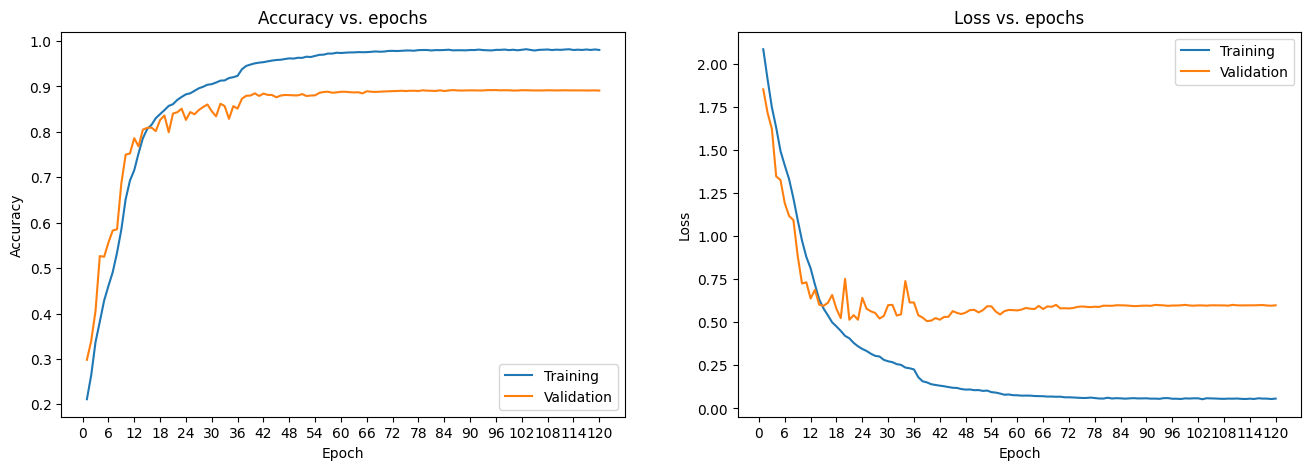

2021-12-02 08:49:18,832: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/vgg8


load best checkpoint from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/vgg8
----------------------------------------evaluate----------------------------------------
y_score.shape=(50000, 10)
y_true.shape=(50000, 10)
len(y_true.shape)=2


2021-12-02 08:49:39,616: INFO: test loss:0.5959
2021-12-02 08:49:39,616: INFO: test accuracy:0.8921
2021-12-02 08:49:39,619: INFO: save model results into /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/results.json
2021-12-02 08:49:39,621: INFO: save json to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/results.json
2021-12-02 08:49:39,621: INFO: saving generator to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/default.generator
2021-12-02 08:49:39,622: INFO: save object to /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/default.generator
2021-12-02 08:49:39,623: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/custom1


y_score.shape=(10000, 10)
y_true.shape=(10000, 10)
len(y_true.shape)=2
----------------------------------------save model results and generator----------------------------------------
----------------------------------------confusion matrix----------------------------------------


2021-12-02 08:49:40,621: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/default.generator


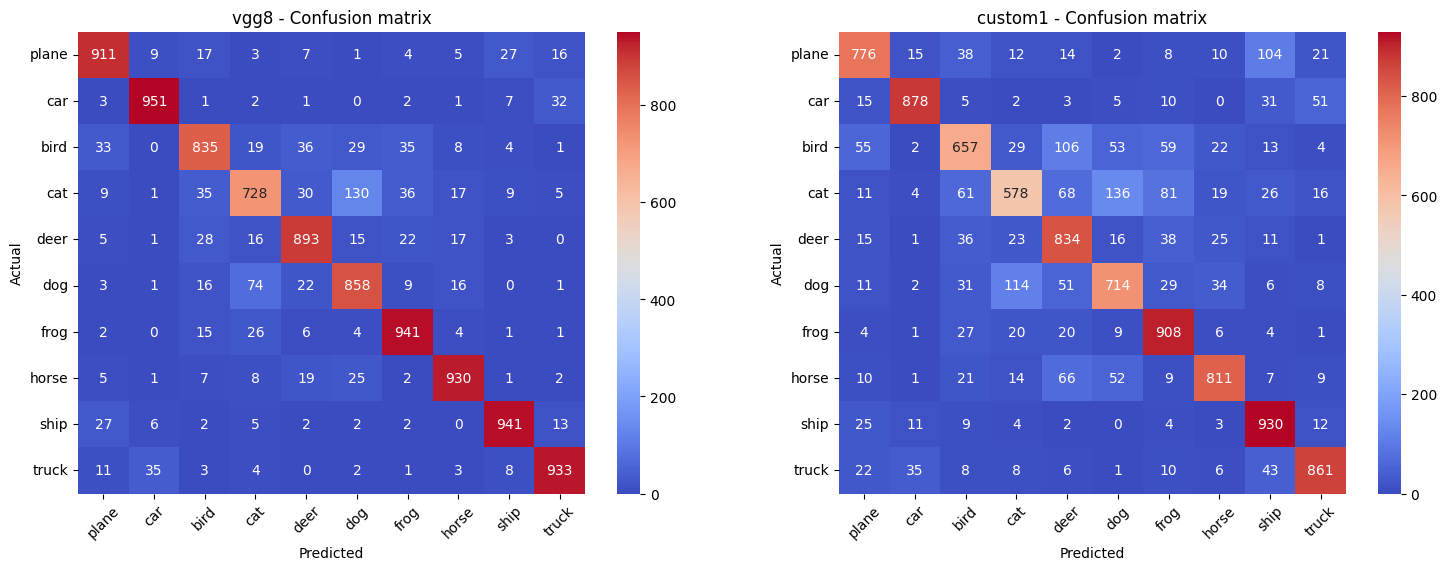

2021-12-02 08:49:44,716: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/custom1


----------------------------------------sample analysis----------------------------------------


2021-12-02 08:49:46,102: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/default.generator
2021-12-02 08:49:46,104: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/lenet1
2021-12-02 08:49:46,929: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/default.generator
2021-12-02 08:49:46,931: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/mlp1
2021-12-02 08:49:47,191: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/default.generator


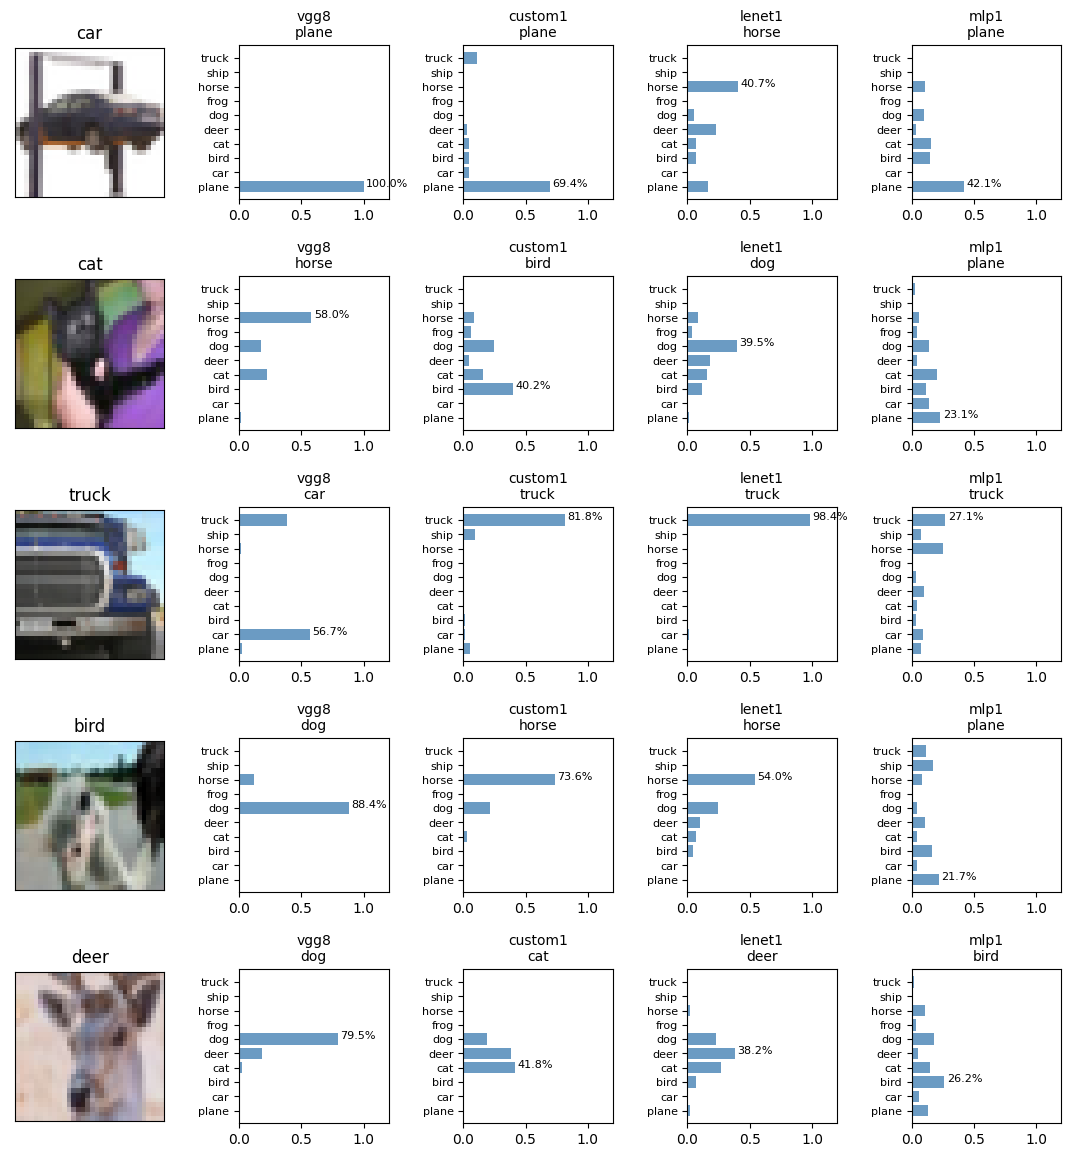

----------------------------------------models----------------------------------------


,model_name,program_name,weight_number,train_time,create_time,train_loss,test_loss,train_accuracy,test_accuracy,train_auc,test_auc
1,vgg8,cifar10_0721_p100.ipynb,1672906,2195.2,2021-12-02 08:49,0.0029,0.5959,0.9995,0.8921,1.0000,0.9920
2,custom1,cifar10_0721_p100.ipynb,73738,1190.8,2021-12-02 08:12,0.3420,0.6094,0.8832,0.7947,0.9929,0.9776
3,lenet1,cifar10_0721_p100.ipynb,83170,1082.5,2021-12-02 07:52,0.4513,0.7808,0.8461,0.7326,0.9878,0.9628
4,mlp1,cifar10_0721_p100.ipynb,394634,612.4,2021-12-02 07:33,1.5857,1.6577,0.4421,0.4093,0.8500,0.8316


In [20]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.vgg1(helper, name='vgg8', dense_layer_count=1, block_count=3,)
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True) 

### Resnet

参考https://github.com/PacktPublishing/Advanced-Deep-Learning-with-Keras/blob/master/chapter2-deep-networks/resnet-cifar10-2.2.1.py

In [21]:
helper = qtf.classification.Classification(params, datasets=datasets, model_results=model_results, task_type='image')
model = qtf.classification.image_models.resnet_v1(helper, name='resnet_v1', depth=20)
model.summary()
history = helper.train(model)
helper.model_summary(model, history, show_sample_analysis=True) 

TensorSpec(shape=(32, 32, 32, 3), dtype=tf.float64, name=None)


2021-12-02 08:49:52,981: INFO: learning_rate=0.001
2021-12-02 08:49:52,982: INFO: model_params.resnet_v1_20.clip_value=None
2021-12-02 08:49:52,989: INFO: checkpoint_path=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/resnet_v1_20
2021-12-02 08:49:53,010: INFO: model_params.resnet_v1_20.epochs=120
2021-12-02 08:49:53,011: INFO: use ModelCheckpoint(filepath=/tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/resnet_v1_20, monitor=val_accuracy)
2021-12-02 08:49:53,011: INFO: use EarlyStopping(monitor=val_accuracy, patience=40)
2021-12-02 08:49:53,012: INFO: use ReduceLROnPlateau(monitor=val_loss, factor=0.31622776601683794, patience=15)
2021-12-02 08:49:53,012: INFO: use LearningRateScheduler()
2021-12-02 08:49:53,013: INFO: steps_per_epoch=1562
2021-12-02 08:49:53,013: INFO: start training
2021-12-02 08:49:53,014: INFO: use_class_weight=False


Model: "resnet_v1_20"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d_5 (Conv2D)              (None, 32, 32, 16)   448         ['input_5[0][0]']                
                                                                                                  
 batch_normalization_5 (BatchNo  (None, 32, 32, 16)  64          ['conv2d_5[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 activation (Activation)        (None, 32, 32, 16)   0           ['batch_normalization_

Epoch 1/120
1561/1562 [============================>.] - ETA: 0s - loss: 1.5257 - accuracy: 0.5056INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/resnet_v1_20/assets


2021-12-02 08:50:44,344: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/resnet_v1_20/assets


1562/1562 [==============================] - 51s 31ms/step - loss: 1.5253 - accuracy: 0.5057 - val_loss: 1.3142 - val_accuracy: 0.5998 - lr: 0.0010


/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.8/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 2/120
1561/1562 [============================>.] - ETA: 0s - loss: 1.0897 - accuracy: 0.6696INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/resnet_v1_20/assets


2021-12-02 08:51:38,742: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/resnet_v1_20/assets


1562/1562 [==============================] - 54s 35ms/step - loss: 1.0895 - accuracy: 0.6697 - val_loss: 1.0974 - val_accuracy: 0.6755 - lr: 0.0010


/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.8/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 3/120
1562/1562 [==============================] - 46s 29ms/step - loss: 0.9121 - accuracy: 0.7388 - val_loss: 1.1473 - val_accuracy: 0.6664 - lr: 0.0010
Epoch 4/120
1560/1562 [============================>.] - ETA: 0s - loss: 0.8036 - accuracy: 0.7809INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/resnet_v1_20/assets


2021-12-02 08:53:26,117: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/resnet_v1_20/assets
/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


1562/1562 [==============================] - 61s 39ms/step - loss: 0.8036 - accuracy: 0.7809 - val_loss: 1.0949 - val_accuracy: 0.6988 - lr: 0.0010


/usr/local/lib/python3.8/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 5/120
1562/1562 [==============================] - 39s 25ms/step - loss: 0.7232 - accuracy: 0.8115 - val_loss: 1.2722 - val_accuracy: 0.6771 - lr: 0.0010
Epoch 6/120
1562/1562 [==============================] - ETA: 0s - loss: 0.6592 - accuracy: 0.8393INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/resnet_v1_20/assets


2021-12-02 08:55:00,534: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/resnet_v1_20/assets


1562/1562 [==============================] - 55s 35ms/step - loss: 0.6592 - accuracy: 0.8393 - val_loss: 1.1292 - val_accuracy: 0.7117 - lr: 0.0010


/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.8/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 7/120
1562/1562 [==============================] - ETA: 0s - loss: 0.6093 - accuracy: 0.8604INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/resnet_v1_20/assets


2021-12-02 08:55:54,501: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/resnet_v1_20/assets


1562/1562 [==============================] - 54s 34ms/step - loss: 0.6093 - accuracy: 0.8604 - val_loss: 1.1930 - val_accuracy: 0.7154 - lr: 0.0010


/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.8/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 8/120
1562/1562 [==============================] - 41s 26ms/step - loss: 0.5719 - accuracy: 0.8775 - val_loss: 1.3749 - val_accuracy: 0.6995 - lr: 0.0010
Epoch 9/120
1561/1562 [============================>.] - ETA: 0s - loss: 0.5488 - accuracy: 0.8885INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/resnet_v1_20/assets


2021-12-02 08:57:28,322: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/resnet_v1_20/assets
/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


1562/1562 [==============================] - 52s 34ms/step - loss: 0.5489 - accuracy: 0.8885 - val_loss: 1.1460 - val_accuracy: 0.7435 - lr: 0.0010


/usr/local/lib/python3.8/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 10/120
1562/1562 [==============================] - 38s 24ms/step - loss: 0.5261 - accuracy: 0.8990 - val_loss: 1.2232 - val_accuracy: 0.7371 - lr: 0.0010
Epoch 11/120
1562/1562 [==============================] - 38s 24ms/step - loss: 0.5103 - accuracy: 0.9075 - val_loss: 1.4405 - val_accuracy: 0.7119 - lr: 0.0010
Epoch 12/120
1562/1562 [==============================] - 37s 24ms/step - loss: 0.4976 - accuracy: 0.9162 - val_loss: 1.3885 - val_accuracy: 0.7110 - lr: 0.0010
Epoch 13/120
1562/1562 [==============================] - 37s 24ms/step - loss: 0.4891 - accuracy: 0.9211 - val_loss: 1.5231 - val_accuracy: 0.7195 - lr: 0.0010
Epoch 14/120
1562/1562 [==============================] - 37s 24ms/step - loss: 0.4843 - accuracy: 0.9256 - val_loss: 1.4041 - val_accuracy: 0.7400 - lr: 0.0010
Epoch 15/120
1562/1562 [==============================] - 39s 25ms/step - loss: 0.4781 - accuracy: 0.9290 - val_loss: 1.5814 - val_accuracy: 0.7247 - lr: 0.0010
Epoch 16/120
1562/1562 [==========

2021-12-02 09:04:37,270: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/resnet_v1_20/assets


1562/1562 [==============================] - 50s 32ms/step - loss: 0.3708 - accuracy: 0.9747 - val_loss: 1.2106 - val_accuracy: 0.7983 - lr: 3.1623e-04


/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.8/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 00021: Still keep learning rate 0.0003162 instead of 0.001
Epoch 21/120
1562/1562 [==============================] - ETA: 0s - loss: 0.3024 - accuracy: 0.9967INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/resnet_v1_20/assets


2021-12-02 09:05:27,219: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/resnet_v1_20/assets
/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


1562/1562 [==============================] - 50s 32ms/step - loss: 0.3024 - accuracy: 0.9967 - val_loss: 1.2876 - val_accuracy: 0.7990 - lr: 3.1623e-04


/usr/local/lib/python3.8/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 00022: Still keep learning rate 0.0003162 instead of 0.001
Epoch 22/120
1562/1562 [==============================] - 38s 24ms/step - loss: 0.2793 - accuracy: 0.9961 - val_loss: 1.4158 - val_accuracy: 0.7884 - lr: 3.1623e-04
Epoch 00023: Still keep learning rate 0.0003162 instead of 0.001
Epoch 23/120
1562/1562 [==============================] - 37s 24ms/step - loss: 0.2801 - accuracy: 0.9898 - val_loss: 1.5064 - val_accuracy: 0.7844 - lr: 3.1623e-04
Epoch 00024: Still keep learning rate 0.0003162 instead of 0.001
Epoch 24/120
1562/1562 [==============================] - ETA: 0s - loss: 0.2631 - accuracy: 0.9933INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/resnet_v1_20/assets


2021-12-02 09:07:33,517: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/resnet_v1_20/assets
/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


1562/1562 [==============================] - 51s 32ms/step - loss: 0.2631 - accuracy: 0.9933 - val_loss: 1.3696 - val_accuracy: 0.7993 - lr: 3.1623e-04


/usr/local/lib/python3.8/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 00025: Still keep learning rate 0.0003162 instead of 0.001
Epoch 25/120
1562/1562 [==============================] - 35s 22ms/step - loss: 0.2534 - accuracy: 0.9928 - val_loss: 1.5158 - val_accuracy: 0.7848 - lr: 3.1623e-04
Epoch 00026: Still keep learning rate 0.0003162 instead of 0.001
Epoch 26/120
1562/1562 [==============================] - 37s 24ms/step - loss: 0.2457 - accuracy: 0.9925 - val_loss: 1.4716 - val_accuracy: 0.7872 - lr: 3.1623e-04
Epoch 00027: Still keep learning rate 0.0003162 instead of 0.001
Epoch 27/120
1562/1562 [==============================] - 37s 23ms/step - loss: 0.2434 - accuracy: 0.9913 - val_loss: 1.4880 - val_accuracy: 0.7860 - lr: 3.1623e-04
Epoch 00028: Still keep learning rate 0.0003162 instead of 0.001
Epoch 28/120
1562/1562 [==============================] - 35s 23ms/step - loss: 0.2353 - accuracy: 0.9924 - val_loss: 1.5637 - val_accuracy: 0.7754 - lr: 3.1623e-04
Epoch 00029: Still keep learning rate 0.0003162 instead of 0.001
Epoch 29/120
15

2021-12-02 09:15:36,883: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/resnet_v1_20/assets
/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


1562/1562 [==============================] - 47s 30ms/step - loss: 0.1730 - accuracy: 1.0000 - val_loss: 1.3579 - val_accuracy: 0.8094 - lr: 1.0000e-04


/usr/local/lib/python3.8/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 00038: Still keep learning rate 0.0001 instead of 0.001
Epoch 38/120
1560/1562 [============================>.] - ETA: 0s - loss: 0.1586 - accuracy: 1.0000INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/resnet_v1_20/assets


2021-12-02 09:16:22,956: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/resnet_v1_20/assets
/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


1562/1562 [==============================] - 46s 29ms/step - loss: 0.1586 - accuracy: 1.0000 - val_loss: 1.3745 - val_accuracy: 0.8104 - lr: 1.0000e-04


/usr/local/lib/python3.8/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 00039: Still keep learning rate 0.0001 instead of 0.001
Epoch 39/120
1562/1562 [==============================] - 34s 22ms/step - loss: 0.1333 - accuracy: 1.0000 - val_loss: 1.3981 - val_accuracy: 0.8070 - lr: 1.0000e-04
Epoch 00040: Still keep learning rate 0.0001 instead of 0.001
Epoch 40/120
1562/1562 [==============================] - 34s 22ms/step - loss: 0.1207 - accuracy: 0.9958 - val_loss: 1.4143 - val_accuracy: 0.8028 - lr: 1.0000e-04
Epoch 00041: Still keep learning rate 0.0001 instead of 0.001
Epoch 41/120
1562/1562 [==============================] - 34s 22ms/step - loss: 0.1075 - accuracy: 0.9995 - val_loss: 1.4100 - val_accuracy: 0.8044 - lr: 1.0000e-04
Epoch 00042: Still keep learning rate 0.0001 instead of 0.001
Epoch 42/120
1047/1562 [===================>..........] - ETA: 10s - loss: 0.1038 - accuracy: 1.0000

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1562/1562 [==============================] - 35s 22ms/step - loss: 0.4994 - accuracy: 0.8675 - val_loss: 1.3065 - val_accuracy: 0.7059 - lr: 0.0010
Epoch 52/120
1562/1562 [==============================] - 35s 22ms/step - loss: 0.4483 - accuracy: 0.8941 - val_loss: 1.0877 - val_accuracy: 0.7517 - lr: 0.0010
Epoch 53/120
1562/1562 [==============================] - 35s 22ms/step - loss: 0.4252 - accuracy: 0.9088 - val_loss: 1.1816 - val_accuracy: 0.7486 - lr: 0.0010
Epoch 54/120
1562/1562 [==============================] - 34s 22ms/step - loss: 0.4097 - accuracy: 0.9200 - val_loss: 1.5098 - val_accuracy: 0.7169 - lr: 0.0010
Epoch 55/120
1562/1562 [==============================] - 34s 22ms/step - loss: 0.4078 - accuracy: 0.9271 - val_loss: 1.1990 - val_accuracy: 0.7603 - lr: 0.0010
Epoch 56/120
1327/1562 [========================>.....] - ETA: 4s - loss: 0.4049 - accuracy: 0.9326

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1562/1562 [==============================] - 34s 22ms/step - loss: 0.1919 - accuracy: 1.0000 - val_loss: 1.2438 - val_accuracy: 0.8179 - lr: 3.1623e-05
Epoch 00067: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 67/120
1561/1562 [============================>.] - ETA: 0s - loss: 0.1741 - accuracy: 1.0000INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/resnet_v1_20/assets


2021-12-02 09:33:36,996: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/resnet_v1_20/assets
/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


1562/1562 [==============================] - 46s 30ms/step - loss: 0.1741 - accuracy: 1.0000 - val_loss: 1.2606 - val_accuracy: 0.8186 - lr: 3.1623e-05


/usr/local/lib/python3.8/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 00068: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 68/120
1562/1562 [==============================] - ETA: 0s - loss: 0.1506 - accuracy: 1.0000INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/resnet_v1_20/assets


2021-12-02 09:34:23,401: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/resnet_v1_20/assets
/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


1562/1562 [==============================] - 46s 30ms/step - loss: 0.1506 - accuracy: 1.0000 - val_loss: 1.2795 - val_accuracy: 0.8195 - lr: 3.1623e-05


/usr/local/lib/python3.8/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 00069: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 69/120
1561/1562 [============================>.] - ETA: 0s - loss: 0.1252 - accuracy: 1.0000INFO:tensorflow:Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/resnet_v1_20/assets


2021-12-02 09:35:09,716: INFO: Assets written to: /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/resnet_v1_20/assets


1562/1562 [==============================] - 46s 30ms/step - loss: 0.1251 - accuracy: 1.0000 - val_loss: 1.3054 - val_accuracy: 0.8197 - lr: 3.1623e-05


/usr/local/lib/python3.8/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.8/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 00070: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 70/120
1562/1562 [==============================] - 34s 22ms/step - loss: 0.1008 - accuracy: 1.0000 - val_loss: 1.3404 - val_accuracy: 0.8182 - lr: 3.1623e-05
Epoch 00071: Still keep learning rate 3.16e-05 instead of 0.0001
Epoch 71/120
1280/1562 [=======================>......] - ETA: 5s - loss: 0.0812 - accuracy: 1.0000

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1560/1562 [============================>.] - ETA: 0s - loss: 0.0388 - accuracy: 0.9998
Epoch 00080: ReduceLROnPlateau reducing learning rate to 9.999999259090306e-06.
1562/1562 [==============================] - 34s 22ms/step - loss: 0.0388 - accuracy: 0.9998 - val_loss: 1.5218 - val_accuracy: 0.8134 - lr: 1.0000e-05
Epoch 00081: Still keep learning rate 1e-05 instead of 0.0001
Epoch 81/120
1562/1562 [==============================] - 34s 22ms/step - loss: 0.0375 - accuracy: 1.0000 - val_loss: 1.5271 - val_accuracy: 0.8133 - lr: 1.0000e-05
Epoch 00082: Still keep learning rate 1e-05 instead of 0.0001
Epoch 82/120
1562/1562 [==============================] - 34s 22ms/step - loss: 0.0373 - accuracy: 1.0000 - val_loss: 1.5341 - val_accuracy: 0.8132 - lr: 1.0000e-05
Epoch 00083: Still keep learning rate 1e-05 instead of 0.0001
Epoch 83/120
1562/1562 [==============================] - 34s 22ms/step - loss: 0.0370 - accuracy: 1.0000 - val_loss: 1.5432 - val_accuracy: 0.8125 - lr: 1.0000e-05


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1562/1562 [==============================] - ETA: 0s - loss: 0.0142 - accuracy: 1.0000
Epoch 00095: ReduceLROnPlateau reducing learning rate to 3.1622775802825263e-06.
1562/1562 [==============================] - 34s 22ms/step - loss: 0.0142 - accuracy: 1.0000 - val_loss: 1.7663 - val_accuracy: 0.8055 - lr: 3.1623e-06
Epoch 00096: Still keep learning rate 3.2e-06 instead of 1e-05
Epoch 96/120
1562/1562 [==============================] - 34s 22ms/step - loss: 0.0141 - accuracy: 1.0000 - val_loss: 1.7670 - val_accuracy: 0.8059 - lr: 3.1623e-06
Epoch 00097: Still keep learning rate 3.2e-06 instead of 1e-05
Epoch 97/120
1562/1562 [==============================] - 35s 22ms/step - loss: 0.0141 - accuracy: 1.0000 - val_loss: 1.7688 - val_accuracy: 0.8065 - lr: 3.1623e-06
Epoch 00098: Still keep learning rate 3.2e-06 instead of 1e-05
Epoch 98/120
1562/1562 [==============================] - 35s 22ms/step - loss: 0.0140 - accuracy: 1.0000 - val_loss: 1.7718 - val_accuracy: 0.8067 - lr: 3.1623e

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



## 评估

### 最佳模型

In [22]:
data_model_results = qtf.classification.DataModelResults(params.data_path) 
data_model_results.show(10)

2021-12-02 09:59:01,346: INFO: getting results for /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10
2021-12-02 09:59:01,348: INFO: load model results from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/results.json


,model_name,program_name,weight_number,train_time,create_time,train_loss,test_loss,train_accuracy,test_accuracy,train_auc,test_auc
1,vgg8,cifar10_0721_p100.ipynb,1672906,2195.2,2021-12-02 08:49,0.0029,0.5959,0.9995,0.8921,1.0000,0.9920
2,resnet_v1_20,cifar10_0721_p100.ipynb,273066,4091.3,2021-12-02 09:58,0.1180,1.3054,0.9985,0.8197,1.0000,0.9791
3,custom1,cifar10_0721_p100.ipynb,73738,1190.8,2021-12-02 08:12,0.3420,0.6094,0.8832,0.7947,0.9929,0.9776
4,lenet1,cifar10_0721_p100.ipynb,83170,1082.5,2021-12-02 07:52,0.4513,0.7808,0.8461,0.7326,0.9878,0.9628
5,mlp1,cifar10_0721_p100.ipynb,394634,612.4,2021-12-02 07:33,1.5857,1.6577,0.4421,0.4093,0.8500,0.8316


In [23]:

predictors = qtf.classification.Predictor.get_top_n_predictors(5, data_model_results)

best_predictor = predictors[0]
best_predictor.model.compile(optimizer=optimizers.Adam(learning_rate=params.learning_rate),
                        loss=losses.SparseCategoricalCrossentropy(from_logits=True),
                        metrics=['accuracy', 'mae'])

qtf.utils.plot_model_structure(best_predictor.model)

2021-12-02 09:59:01,428: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/vgg8
2021-12-02 09:59:03,097: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/default.generator
2021-12-02 09:59:03,102: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/resnet_v1_20
2021-12-02 09:59:07,937: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/default.generator
2021-12-02 09:59:07,942: INFO: loading model from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/image_classification/output/cifar10/cifar10_0721_p100/custom1
2021-12-02 09:59:09,960: INFO: loading generator from /tf/eipi10/xuxiangwen.github.io/_notes/05-ai/54-tensorflow/im

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


None

2021-12-02 09:59:12,096: WARNING: 5 out of the last 25 calls to <function Model.make_predict_function.<locals>.predict_function at 0x7f83e45f0ee0> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


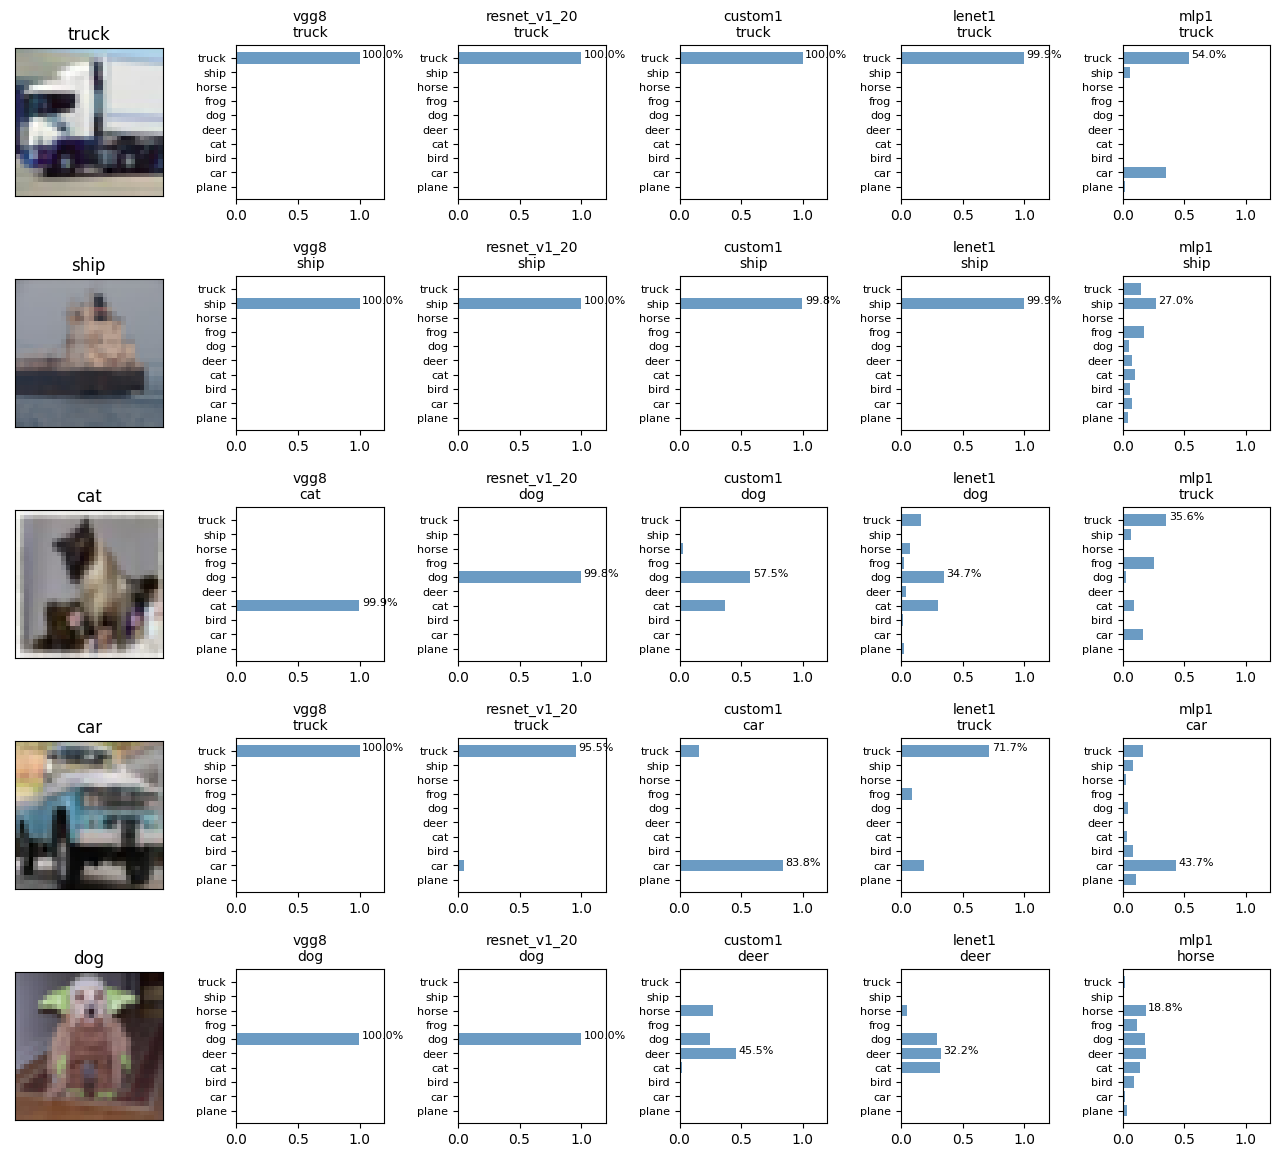

In [24]:
qtf.utils.plot_sample_image_analysis(predictors, test_images, test_labels,
                                    sample_count=5, show_error_sample=False) 

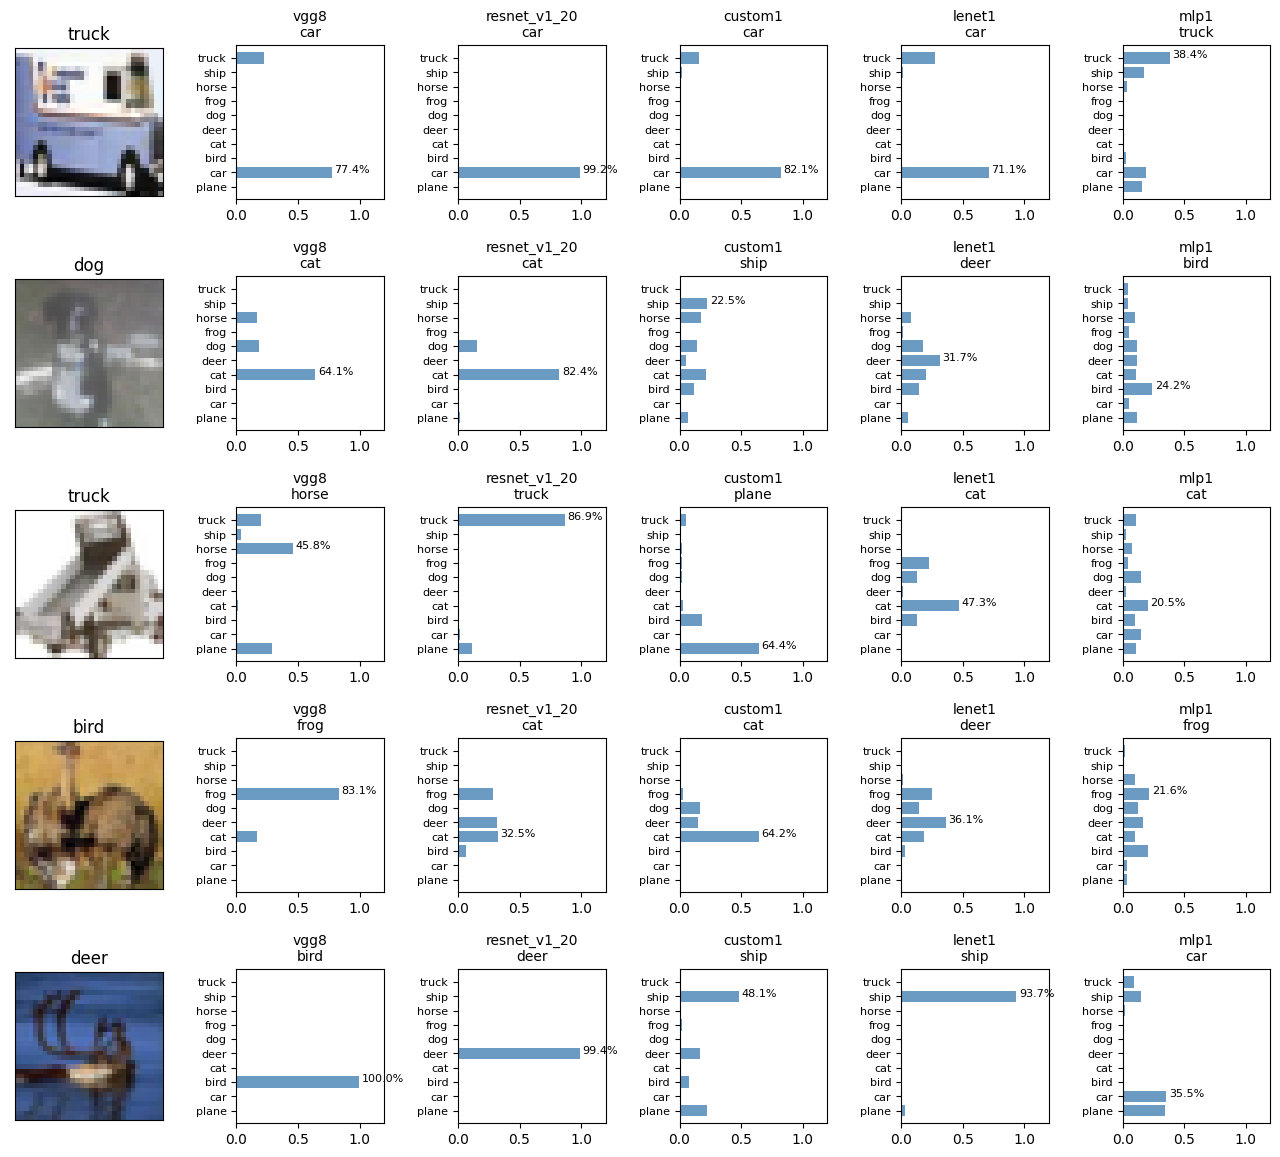

In [25]:
qtf.utils.plot_sample_image_analysis(predictors, test_images, test_labels,
                                    sample_count=5, show_error_sample=True) 

### 评估

In [26]:
results = best_predictor.evaluate(test_images, test_labels)
print(results)

predictions = best_predictor.predict(test_images)
print(predictions.shape)

{'loss': 0.5958889126777649, 'accuracy': 0.8920999765396118, 'mae': 23.795488357543945}
(10000, 10)


In [27]:
top1_predictions = best_predictor.predict_top_k(test_images, test_labels, top_k=1)
top1_scores = qtf.utils.score(test_labels, top1_predictions, params.classes)
display(top1_scores)
print('-'*100)
print(classification_report(test_labels, top1_predictions, digits=4, target_names=params.classes))

,precision,recall,f1
plane,0.902874,0.911,0.906919
car,0.946269,0.951,0.948628
bird,0.870699,0.835,0.852476
cat,0.822599,0.728,0.772414
deer,0.878937,0.893,0.885913
dog,0.804878,0.858,0.830591
frog,0.892789,0.941,0.916261
horse,0.929071,0.930,0.929535
ship,0.940060,0.941,0.940530
truck,0.929283,0.933,0.931138


----------------------------------------------------------------------------------------------------
              precision    recall  f1-score   support

       plane     0.9029    0.9110    0.9069      1000
         car     0.9463    0.9510    0.9486      1000
        bird     0.8707    0.8350    0.8525      1000
         cat     0.8226    0.7280    0.7724      1000
        deer     0.8789    0.8930    0.8859      1000
         dog     0.8049    0.8580    0.8306      1000
        frog     0.8928    0.9410    0.9163      1000
       horse     0.9291    0.9300    0.9295      1000
        ship     0.9401    0.9410    0.9405      1000
       truck     0.9293    0.9330    0.9311      1000

    accuracy                         0.8921     10000
   macro avg     0.8917    0.8921    0.8914     10000
weighted avg     0.8917    0.8921    0.8914     10000



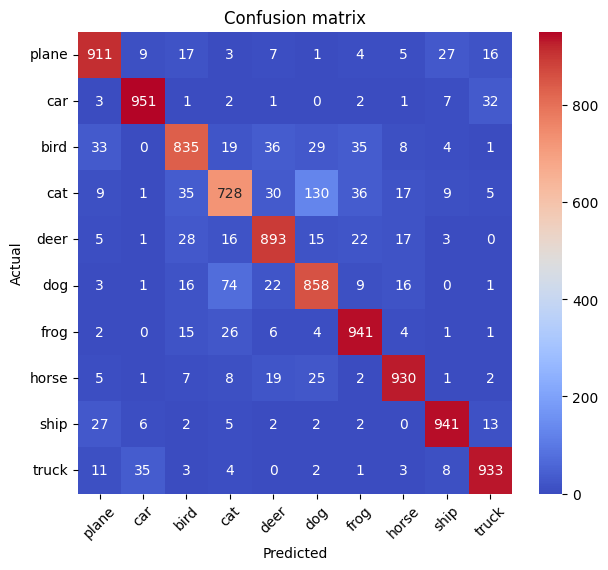

In [28]:
qtf.utils.plot_confusion_matrix(test_labels, top1_predictions, params.classes)


## 参考

- [Text classification Guide](https://developers.google.com/machine-learning/guides/text-classification)

In [29]:
type(helper.datasets.train_dataset)

tensorflow.python.data.ops.dataset_ops.PrefetchDataset